# Final Project Submission

Please fill out:
* Student name: Jonathan Roman
* Student pace: DS Flex
* Scheduled project review date/time: August 16th, 2022, 4PM
* Instructor name: Claude Fried
* Blog post URL:

# Summary

This notebook dives into the world of Pnuemonia Detection using Neural Networks. Neural Networks are a great framework for processing image data since image data is quite complex. 

<h3 align="center"><b><u>Business Problem</b></u></h3>

The stakeholder for this project will be a hospital who specializes in pneumonia care and would like to leverage technology in their day to day process. This technology has the opportunity to be used as a screening measure to help doctors become more efficient in helping patients who have pneumonia by identifying cases and bringing them in to ensure proper care.

<h3 align="center"><b><u>Data Understanding</b></u></h3>

The information provided in this notebook was provided by kaggle at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia. This was a less intensive version of the data from https://data.mendeley.com/datasets/rscbjbr9sj/2. The information came with a train, validation and test set, each with a folder labeled "NORMAL" and "PNEUMONIA". The validation set vastly lacked information, therefore, information from the train set was moved into the validation set before any processing or modeling preparations.

<h3 align="center"><b><u>Data Preparation</b></u></h3>

For the preparation section of this notebook, packages from sklearn, tensorflow, matplotlib, numpy, seaborn and os were used to complete this project. Tensorflow was used to model using neural networks while sklearn was used for evaluation. Numpy was key to converting information into arrays for the neural networks to process. Matplotlib and seaborn were used for visualization purposes. os was necessary to get the information from the local drive into this notebook. For the start of the preparation, we wanted to know how much information we were working with so there were counts of the information in each folder. There were also displays of examples of what was considered a normal xray and an xray for someone who had pneumonia. The dataset was normalized to work well with the neural network and a generator was used to prepare the information. Class weights were also calculated because the dataset was imalanced and needed to be addressed. 

<h3 align="center"><b><u>Modeling</b></u></h3>

During the modeling section of this notebook, there were iterative tweaks to the models to see how it will affect the performance towards achieving the goal of making a useful model. There were tweaks to nodes, optimizers, dropout and learning rates. There were also tweaks to fit parameters such as epochs and validation steps. The process started with a very basic neural network containing an input layer, hidden layer, and an output layer. An HParams search was used to go through different parameters inside of the neural network to see which will perform the best and then progressively tweak the neural network further. Afterwards, transfer learning was used in comparison to the tweaks of the model. Transfer learning ultimately succeeded to becoming the final model used on the test set since it had the most stable training loss and validation loss with a decent percentage of detection of pneumonia compared to other models.

<h3 align="center"><b><u>Evaluation</b></u></h3>

Evaluating each model (except for the HParams model because it would be too resource intensive at the moment) was evaluated using a visualization of the training loss and the validation loss. An accompanying validation confusion matrix allowed for closer inspection as to how a model will perform in terms of its predictions.

<h3 align="center"><b><u>Conclusion</b></u></h3>

The result of this project was unsuccessful in its detection ability and would need to continue to be worked on to further strengthen its ability to detect. The test set had a data imbalance of a 62.5% towards Pneumonia. Although the results for accuracy in the evaluate method of the test set provided by tensorflow was about ~73.2%, The best model in this notebook was only able to detect a Pneumonia patient who had it ~36.3% of the time and misdiagnosed a patient who actually had Pneumonia as Normal ~62.8 of the time.

# Data Preparation

In [1]:
#Importing the necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import RocCurveDisplay 
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

#Making the directories to access the information
train_directory= 'data/chest_xray/train'
validation_directory= 'data/chest_xray/val'
test_directory = 'data/chest_xray/test'

In [2]:
#Getting the counts for each directory
print("Train set:")
num_pneumonia = len(os.listdir(os.path.join(train_directory, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_directory, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")
print("\n")
print("Validation set:")
print(f'PNEUMONIA={len(os.listdir(os.path.join(validation_directory, "PNEUMONIA")))}')
print(f'NORMAL={len(os.listdir(os.path.join(validation_directory, "NORMAL")))}')
print("\n")
print('Test set:')
print(f'PNEUMONIA={len(os.listdir(os.path.join(test_directory, "PNEUMONIA")))}')
print(f'NORMAL={len(os.listdir(os.path.join(test_directory, "NORMAL")))}')

Train set:
PNEUMONIA=3575
NORMAL=1041


Validation set:
PNEUMONIA=308
NORMAL=308


Test set:
PNEUMONIA=390
NORMAL=234


Examples of a normal xray:
-------------------------------


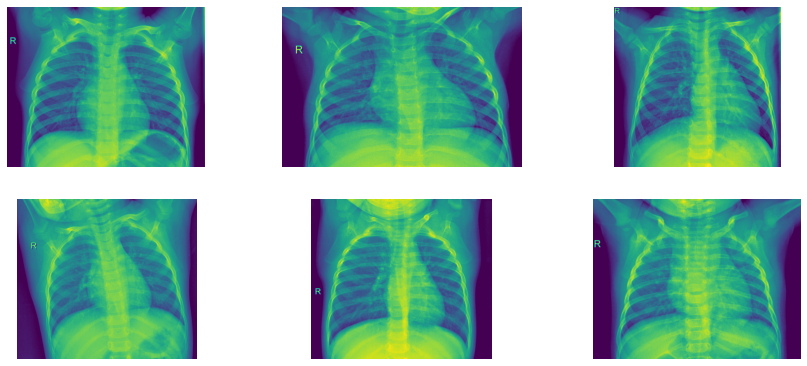

In [3]:
#Displaying examples of a normal xray
print('Examples of a normal xray:\n-------------------------------')
normal = os.listdir("data/chest_xray/train/NORMAL")
normal_directory = "data/chest_xray/train/NORMAL"

plt.figure(figsize = (15,10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(normal_directory, normal[i]))
    plt.imshow(img)
    plt.axis('off')


Examples of a pneumonia xray:
-------------------------------


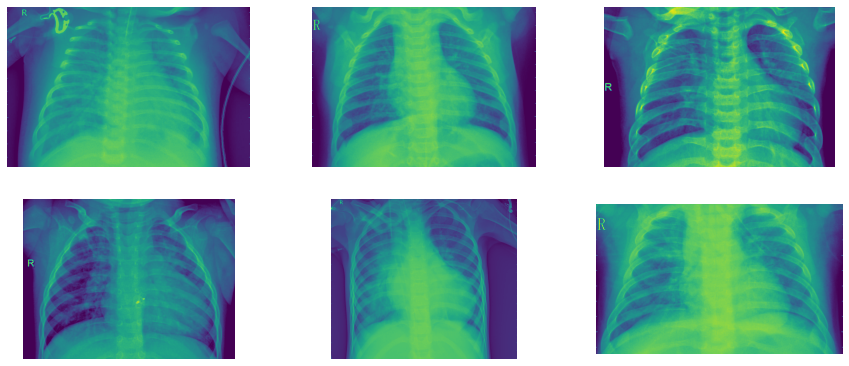

In [4]:
#Displaying examples of a pneumonia xray
print('Examples of a pneumonia xray:\n-------------------------------')
pneumonia = os.listdir("data/chest_xray/train/PNEUMONIA")
pneumonia_directory = "data/chest_xray/train/PNEUMONIA"

plt.figure(figsize = (15,10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(pneumonia_directory, pneumonia[i]))
    plt.imshow(img)
    plt.axis('off')

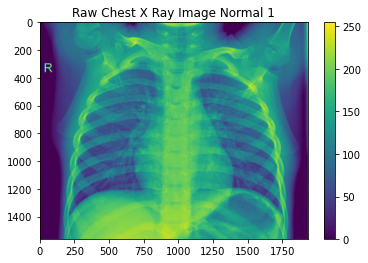

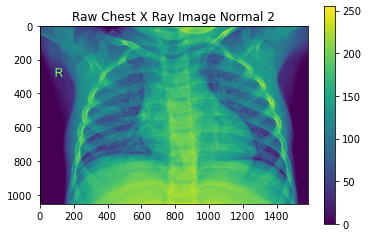

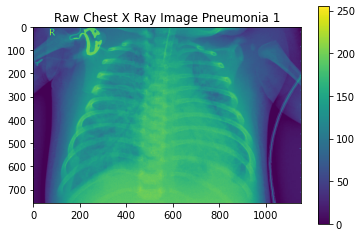

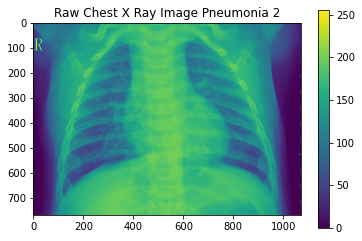

In [5]:
img_norm_1 = os.listdir("data/chest_xray/train/NORMAL")[0]
img_norm_2 = os.listdir("data/chest_xray/train/NORMAL")[1]
img_pnu_1 = os.listdir("data/chest_xray/train/PNEUMONIA")[0]
img_pnu_2 = os.listdir("data/chest_xray/train/PNEUMONIA")[1]


sample_img_norm_1 = plt.imread(os.path.join(normal_directory, img_norm_1))
sample_img_norm_2 = plt.imread(os.path.join(normal_directory, img_norm_2))
sample_img_pnu_1 = plt.imread(os.path.join(pneumonia_directory, img_pnu_1))
sample_img_pnu_2 = plt.imread(os.path.join(pneumonia_directory, img_pnu_2))

plt.imshow(sample_img_norm_1)
plt.colorbar()
plt.title('Raw Chest X Ray Image Normal 1')
plt.show()
plt.imshow(sample_img_norm_2)
plt.colorbar()
plt.title('Raw Chest X Ray Image Normal 2')
plt.show()
plt.imshow(sample_img_pnu_1)
plt.colorbar()
plt.title('Raw Chest X Ray Image Pneumonia 1')
plt.show()
plt.imshow(sample_img_pnu_2)
plt.colorbar()
plt.title('Raw Chest X Ray Image Pneumonia 2')
plt.show()

In [6]:
def plot_image_histogram(img_1, img_2):
    fig, ax = plt.subplots(figsize = (12, 10))
    sns.histplot(img_1.ravel(), bins = 150,)
    plt.title('Distribution of Pixel Intensities in the Normal Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Number of pixels in the image')
    plt.show()
    
    fig, ax = plt.subplots(figsize = (12, 10))
    sns.histplot(img_2.ravel(), bins = 150)
    plt.title('Distribution of Pixel Intensities in the Pneumonia Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Number of pixels in the image')
    plt.show()





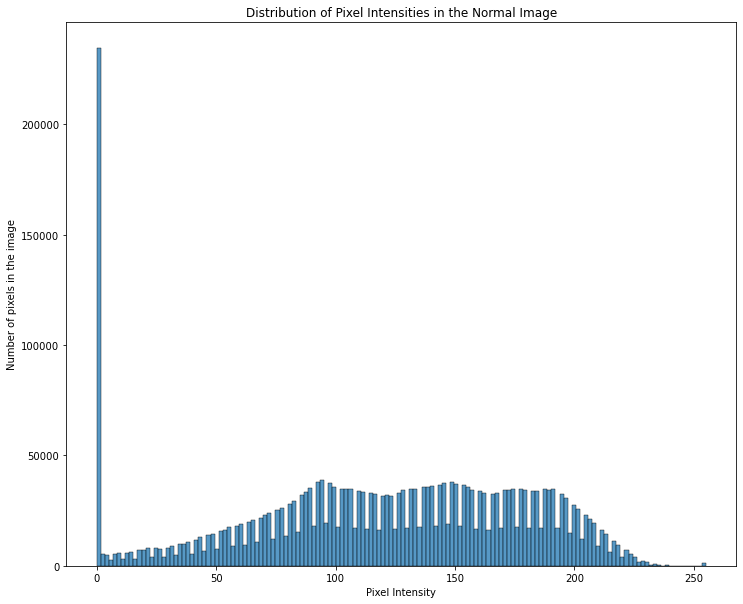

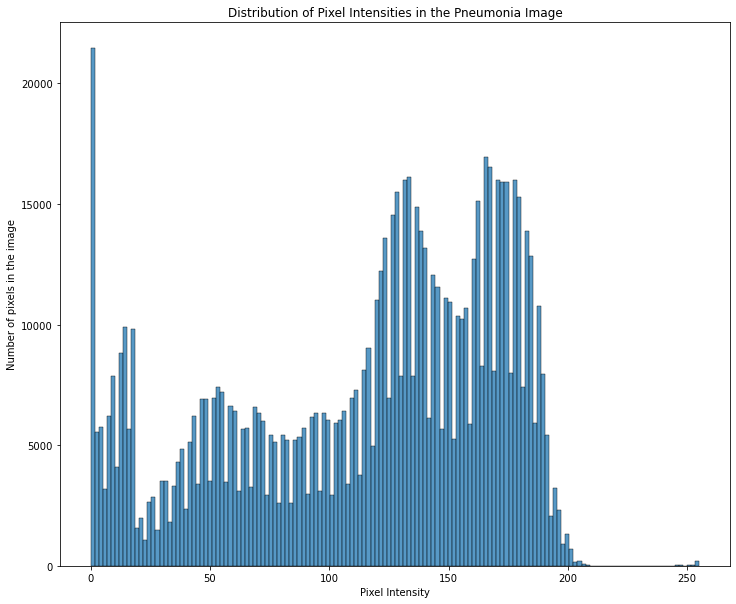

In [7]:
plot_image_histogram(sample_img_norm_1, sample_img_pnu_1)

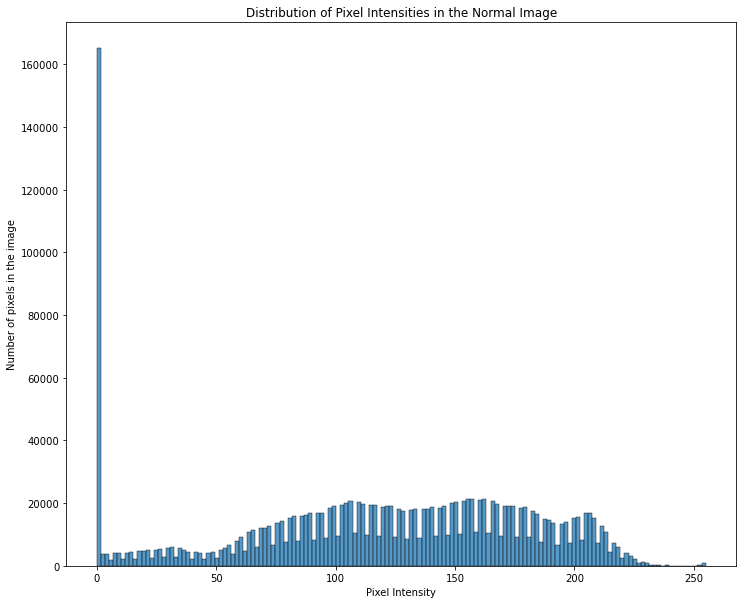

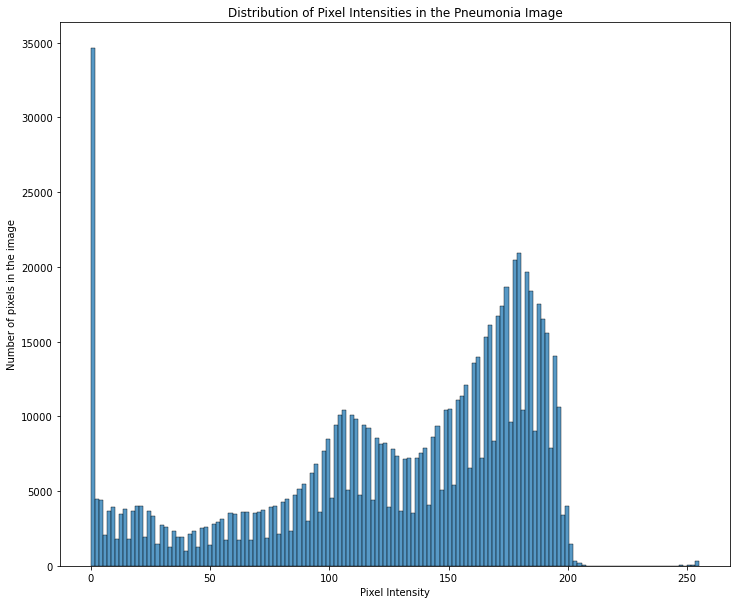

In [8]:
plot_image_histogram(sample_img_norm_2, sample_img_pnu_2)

In [9]:
#Normalizing the data
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

#Using a generator for the images to work with.
train_generator = train_datagen.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                   batch_size=32,
                                                   class_mode = 'binary',
                                                   shuffle=True)

validation_generator = val_datagen.flow_from_directory(validation_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      class_mode = 'binary',
                                                      shuffle=True)

Found 4616 images belonging to 2 classes.
Found 616 images belonging to 2 classes.


In [10]:
#Checking the classification of the information
train_generator.class_indices
validation_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
#Calculating class weights to deal with data imbalance
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia) 
weight_for_1 = num_normal / (num_normal + num_pneumonia)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.77
Weight for class 1: 0.23


## Metric functions preparation

In [12]:
#Creating function to evaluate training loss and validation loss 
def evaluate_nn(history):
    '''
    This function plots the training accuracy, validation accuracy, training loss and validation loss from a fitted keras model.
    It gets this information from the history.history and the metric attributed to the model.
    
    '''
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'blue', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'blue', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'orange', label= 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

In [13]:
#Creating function to get a confusion matrix
def get_predictions(model, generator):
    '''
    This function gets the predictions from a model using a generator and gathers the true values along with the 
    predicted values to be inputted into any function that needs label(true values) and prediction(predicted) values. This
    functions serves as a way to work with generators that have shuffle = True turned on.
    '''
    
    '''
    source: https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict
    -generator/67282636#67282636
    
    '''
    
    # Create lists for storing the predictions and labels
    predictions = []
    labels = []

    # Get the total number of labels in generator 
    # (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

    # Loop over the generator
    for data, label in generator:
        # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data).flatten())

        # Store corresponding labels
        labels.extend(label)

        # We have to break out from the generator when we've processed 
        # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
    return labels, predictions

In [14]:
#Creating a function to plot 
def plot_confusion_matrix(y_true, y_pred):
    '''
    This function plots a regular confusion matrix. It takes predictions generated from the get_predictions
    function and calculates true positive, false positive, true negative and false negative counts.
    
    '''
    #Converting probabilities to 0 and 1
    y_pred = np.array([round(x) for x in y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    
    #Plotting confusion matrix using heatmap
    fig, ax = plt.subplots(figsize = (16, 10))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

    ax.set_title('Predictions for Pneumonia cases\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

    ## Display the visualization of the Confusion Matrix.
    plt.show();

In [15]:
#Creating a function to plot 
def plot_confusion_matrix_normalized(y_true, y_pred):
    
    #Converting probabilities to 0 and 1
    y_pred = np.array([round(x) for x in y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    
    '''
    This function plots a normalized confusion matrix. It takes predictions generated from the get_predictions
    functionand calculates true positive, false positive, true negative and false negative counts. It then turns the 
    confusion matrix counts into percentages for easier intepretation.
    
    '''
    #Calculating normalization
    row_sums = cm.sum(axis=1)
    new_matrix = np.round(cm / row_sums[:, np.newaxis], 3)
    
    #Plotting confusion matrix using heatmap
    fig, ax = plt.subplots(figsize = (16, 10))
    ax = sns.heatmap(new_matrix, annot=True, cmap='Blues', fmt='g')

    ax.set_title('Predictions for Pneumonia cases\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

    ## Display the visualization of the Confusion Matrix.
    plt.show();

In [16]:
def plot_roc_auc(y_true, y_score):
    """
    This function plots an ROC curve and gives the AUC score of a model's predictions and a generator's true labels.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Modeling

## Model 1 - Baseline

In [17]:
#Initializing Model
model_1 = models.Sequential()

#Adding CNN input layer
model_1.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model_1.add(layers.MaxPooling2D(2,2))

#Adding Dense hidden layer
model_1.add(layers.Flatten())
model_1.add(layers.Dense(256, activation = 'relu'))

#Adding output layer with sigmoid for binary classification
model_1.add(layers.Dense(1, activation = 'sigmoid'))

#Compiling the model
model_1.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.RMSprop(lr=1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [18]:
#Checking model summary to see how many params will be trained
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               100933888 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 100,935,041
Trainable params: 100,935,041
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Fitting model and adding class weights
history = model_1.fit(train_generator, #Using train data
                      epochs = 10, #Starting with 10 epochs
                      validation_data = validation_generator, #Using validation data
                      class_weight = class_weight, #Adding weights to deal with imbalance
                      steps_per_epoch = 100, #Starting with 100 steps
                      validation_steps = 10)#Starting with 10 validation steps

Epoch 1/10
100/100 [==============================] - 68s 683ms/step - loss: 0.7238 - binary_accuracy: 0.6606 - val_loss: 0.6169 - val_binary_accuracy: 0.6594
Epoch 2/10
100/100 [==============================] - 69s 687ms/step - loss: 0.1488 - binary_accuracy: 0.8134 - val_loss: 0.2521 - val_binary_accuracy: 0.8906
Epoch 3/10
100/100 [==============================] - 69s 689ms/step - loss: 0.1051 - binary_accuracy: 0.8766 - val_loss: 0.3853 - val_binary_accuracy: 0.8625
Epoch 4/10
100/100 [==============================] - 69s 693ms/step - loss: 0.0824 - binary_accuracy: 0.9024 - val_loss: 0.1173 - val_binary_accuracy: 0.9563
Epoch 5/10
100/100 [==============================] - 69s 691ms/step - loss: 0.0674 - binary_accuracy: 0.9251 - val_loss: 0.2591 - val_binary_accuracy: 0.8781
Epoch 6/10
100/100 [==============================] - 69s 693ms/step - loss: 0.0548 - binary_accuracy: 0.9386 - val_loss: 0.1011 - val_binary_accuracy: 0.9750
Epoch 7/10
100/100 [==========================

## Evaluation - Model 1

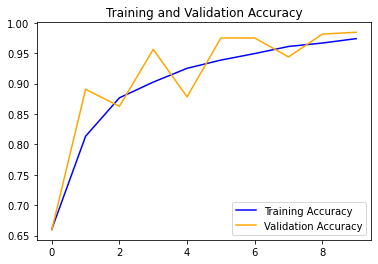

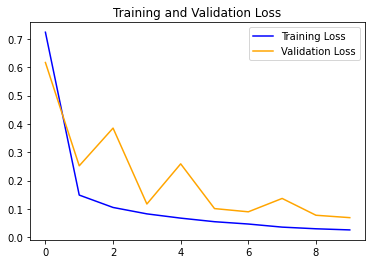

<Figure size 432x288 with 0 Axes>

In [20]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history)

In [21]:
predictions_1 = get_predictions(model_1, validation_generator)

AUC: 0.9955936920222634


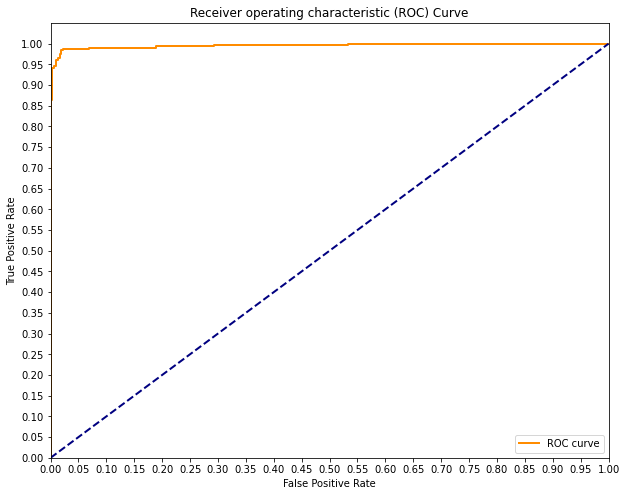

In [22]:
plot_roc_auc(predictions_1[0], predictions_1[1])

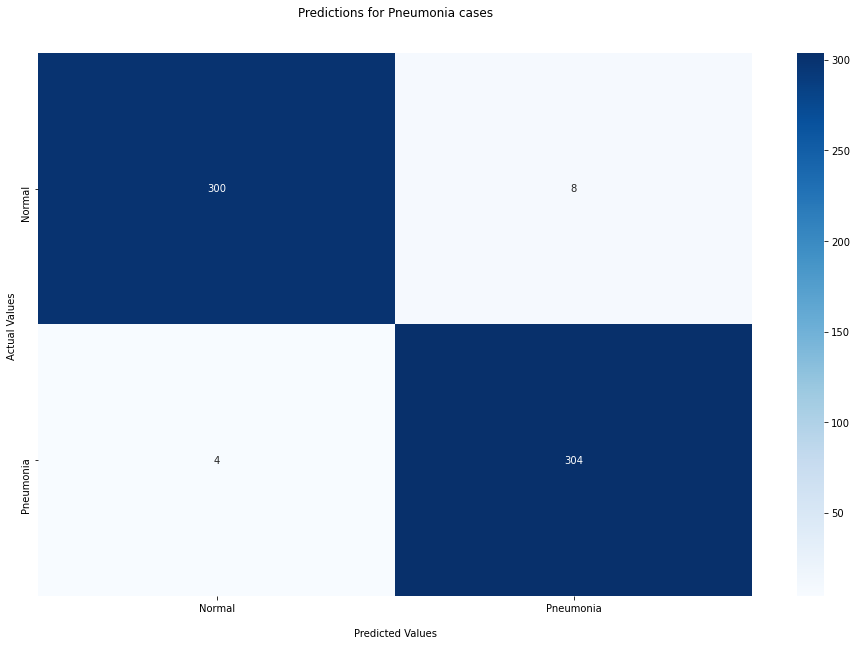

In [23]:
plot_confusion_matrix(predictions_1[0], predictions_1[1])

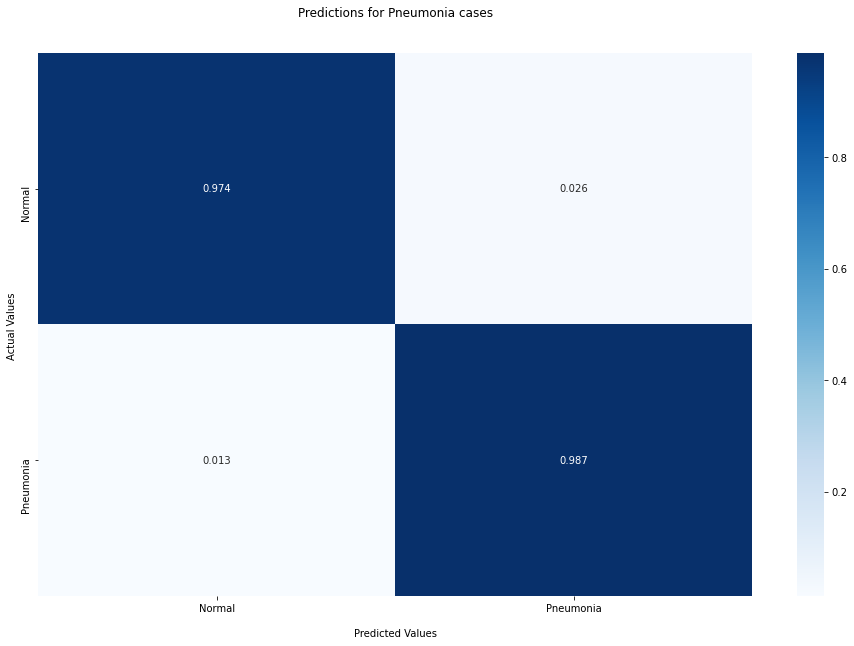

In [24]:
plot_confusion_matrix_normalized(predictions_1[0], predictions_1[1])

## Conclusion - Model 1

Baseline model did very well to start. Validation accuracy did better than the training accuracy which is not so common but still great. The loss for both the validation set and training set, while not directly parallel, are trending in the same direction. The ROC curve looks very promising with an <b>AUC of 99%</b>. The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>98.7%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>1.3%</b> of the time. 

## Model 2 - HParams

In [25]:
#Specifying the parameters inside of the neural network that should be searched through
HP_NUM_UNITS=hp.HParam('num_units', hp.Discrete([128, 256]))
HP_DROPOUT=hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.01, 0.001, 0.0001]))
HP_OPTIMIZER=hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop']))
METRIC_ACCURACY='binary_accuracy'
    

In [26]:
#Creating a directory for logs
logdir = 'logs/hparam_tuning'

In [27]:
#Creating a folder to keep written logs
with tf.summary.create_file_writer(logdir).as_default():
    hp.hparams_config(
    hparams=
    [HP_NUM_UNITS, HP_DROPOUT,  HP_OPTIMIZER, HP_LEARNING_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='binary_accuracy')],
    )

In [28]:
#Creating function to do an HParams search
def create_model_grid(hparams):
    '''
    
    This function uses the baseline model as it's base model. It changes the nodes, optimizer, dropout and learning rate based 
    on the set params in the HParams. 
    
    '''
    #Initializing model
    model = models.Sequential()
    
    #Adding CNN input layer
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    
    #Adding Dense hidden layer
    model.add(layers.Flatten())
    model.add(layers.Dense(hparams[HP_NUM_UNITS], activation = 'relu'))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    
    #Adding output layer
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    #Looping through optimizers and learning rates
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
    
    #Compiling model
    model.compile(loss= 'binary_crossentropy', 
    optimizer= optimizer, 
    metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))
    
    #Fitting model
    history=model.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=10, #Keeping 10 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=10, #Keeping 10 steps
    )
    
    return history.history['val_binary_accuracy'][-1]

In [29]:
#Recording the logs for each model generated
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = create_model_grid(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [30]:
#Looping through each Hparam with a different model
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
              HP_LEARNING_RATE: learning_rate,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units': 128, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.0001}
Epoch 1/10
100/100 [==============================] - 48s 476ms/step - loss: 0.2014 - binary_accuracy: 0.7670 - val_loss: 0.2826 - val_binary_accuracy: 0.9094
Epoch 2/10
100/100 [==============================] - 47s 474ms/step - loss: 0.0814 - binary_accuracy: 0.9137 - val_loss: 0.1942 - val_binary_accuracy: 0.9219
Epoch 3/10
100/100 [==============================] - 48s 476ms/step - loss: 0.0621 - binary_accuracy: 0.9364 - val_loss: 0.1420 - val_binary_accuracy: 0.9625
Epoch 4/10
100/100 [==============================] - 48s 478ms/step - loss: 0.0497 - binary_accuracy: 0.9469 - val_loss: 0.1286 - val_binary_accuracy: 0.9531
Epoch 5/10
100/100 [==============================] - 48s 475ms/step - loss: 0.0494 - binary_accuracy: 0.9487 - val_loss: 0.1813 - val_binary_accuracy: 0.9187
Epoch 6/10
100/100 [==============================] - 48s 478ms/step - loss: 0.0494 - binary_accur

100/100 [==============================] - 56s 559ms/step - loss: 0.0980 - binary_accuracy: 0.9553 - val_loss: 0.4089 - val_binary_accuracy: 0.8938
Epoch 10/10
100/100 [==============================] - 55s 549ms/step - loss: 0.0285 - binary_accuracy: 0.9741 - val_loss: 9.9750 - val_binary_accuracy: 0.5281
--- Starting trial: run-5
{'num_units': 128, 'dropout': 0.1, 'optimizer': 'rmsprop', 'learning_rate': 0.01}
Epoch 1/10
100/100 [==============================] - 55s 551ms/step - loss: 26.5530 - binary_accuracy: 0.7487 - val_loss: 0.4012 - val_binary_accuracy: 0.8656
Epoch 2/10
100/100 [==============================] - 55s 547ms/step - loss: 2.6012 - binary_accuracy: 0.8133 - val_loss: 0.4443 - val_binary_accuracy: 0.8562
Epoch 3/10
100/100 [==============================] - 54s 543ms/step - loss: 0.6724 - binary_accuracy: 0.8423 - val_loss: 0.4930 - val_binary_accuracy: 0.8406
Epoch 4/10
100/100 [==============================] - 54s 544ms/step - loss: 0.7563 - binary_accuracy: 0.8

100/100 [==============================] - 55s 552ms/step - loss: 0.0358 - binary_accuracy: 0.9603 - val_loss: 0.0726 - val_binary_accuracy: 0.9719
Epoch 8/10
100/100 [==============================] - 56s 557ms/step - loss: 0.0302 - binary_accuracy: 0.9694 - val_loss: 0.1892 - val_binary_accuracy: 0.9219
Epoch 9/10
100/100 [==============================] - 56s 556ms/step - loss: 0.0282 - binary_accuracy: 0.9694 - val_loss: 0.1852 - val_binary_accuracy: 0.9187
Epoch 10/10
100/100 [==============================] - 55s 551ms/step - loss: 0.0255 - binary_accuracy: 0.9742 - val_loss: 0.1018 - val_binary_accuracy: 0.9563
--- Starting trial: run-10
{'num_units': 128, 'dropout': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.001}
Epoch 1/10
100/100 [==============================] - 57s 565ms/step - loss: 1.8592 - binary_accuracy: 0.7713 - val_loss: 0.3024 - val_binary_accuracy: 0.9031
Epoch 2/10
100/100 [==============================] - 55s 547ms/step - loss: 0.1839 - binary_accuracy: 0.

100/100 [==============================] - 57s 574ms/step - loss: 0.0555 - binary_accuracy: 0.9416 - val_loss: 0.3579 - val_binary_accuracy: 0.8438
Epoch 6/10
100/100 [==============================] - 57s 571ms/step - loss: 0.0553 - binary_accuracy: 0.9525 - val_loss: 0.3884 - val_binary_accuracy: 0.8594
Epoch 7/10
100/100 [==============================] - 57s 569ms/step - loss: 0.0386 - binary_accuracy: 0.9581 - val_loss: 0.4192 - val_binary_accuracy: 0.8562
Epoch 8/10
100/100 [==============================] - 57s 573ms/step - loss: 0.0280 - binary_accuracy: 0.9681 - val_loss: 0.6435 - val_binary_accuracy: 0.8156
Epoch 9/10
100/100 [==============================] - 58s 578ms/step - loss: 0.0271 - binary_accuracy: 0.9739 - val_loss: 0.3553 - val_binary_accuracy: 0.8906
Epoch 10/10
100/100 [==============================] - 57s 570ms/step - loss: 0.0199 - binary_accuracy: 0.9758 - val_loss: 0.4147 - val_binary_accuracy: 0.8969
--- Starting trial: run-15
{'num_units': 256, 'dropout':

100/100 [==============================] - 57s 565ms/step - loss: 0.0289 - binary_accuracy: 0.9707 - val_loss: 0.1092 - val_binary_accuracy: 0.9688
Epoch 4/10
100/100 [==============================] - 58s 575ms/step - loss: 0.0149 - binary_accuracy: 0.9855 - val_loss: 0.1090 - val_binary_accuracy: 0.9563
Epoch 5/10
100/100 [==============================] - 57s 571ms/step - loss: 0.0115 - binary_accuracy: 0.9877 - val_loss: 0.0990 - val_binary_accuracy: 0.9750
Epoch 6/10
100/100 [==============================] - 56s 565ms/step - loss: 0.0118 - binary_accuracy: 0.9902 - val_loss: 0.1838 - val_binary_accuracy: 0.9375
Epoch 7/10
100/100 [==============================] - 56s 564ms/step - loss: 0.0111 - binary_accuracy: 0.9880 - val_loss: 0.0859 - val_binary_accuracy: 0.9594
Epoch 8/10
100/100 [==============================] - 57s 566ms/step - loss: 0.0057 - binary_accuracy: 0.9946 - val_loss: 0.1338 - val_binary_accuracy: 0.9594
Epoch 9/10
100/100 [==============================] - 57s

## Conclusion - Model 2

Through this search, the best model that will be chosen and iterated on will be:
<b>
* Dense hidden layer: Node = 256
* Optimizer = Adam
* Dropout = 0.1
* Learning rate = 0.0001 </b>  

## Model 3

After the HParams search, the best model in terms of the consistent val_acc score would be the model that has:
* One input CNN layer: Node = 32
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1
* Optimizer = Adam
* Dropout = 0.1
* Learning rate = 0.0001

With this model, it will be adjusted with: 
* Learning rate = 0.00001
* An additional CNN layer with same parameters as input

In [31]:
#Initializing model
model_3 = models.Sequential()

#Adding CNN input layer
model_3.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model_3.add(layers.MaxPooling2D(2,2))
model_3.add(layers.Dropout(0.1))

#Adding CNN hidden layer
model_3.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model_3.add(layers.MaxPooling2D(2,2))
model_3.add(layers.Dropout(0.1))

#Flattening and adding another Dense hidden layer
model_3.add(layers.Flatten())
model_3.add(layers.Dense(256, activation = 'relu'))
model_3.add(layers.Dropout(0.1))

#Adding output layer
model_3.add(layers.Dense(1, activation = 'sigmoid'))

#Compiling model
model_3.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=1e-5), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [32]:
#Checking model summary to see how many params will be trained
model_3.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 93312)           

In [33]:
#Fitting model to the data
history_3=model_3.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Staying with 100 steps per epoch
    epochs=10, #Staying with starting epoch
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, ##Adding weights to deal with imbalance
    validation_steps=10) #Staying with 10 steps

Epoch 1/10
100/100 [==============================] - 65s 647ms/step - loss: 0.1870 - binary_accuracy: 0.7720 - val_loss: 0.4960 - val_binary_accuracy: 0.8031
Epoch 2/10
100/100 [==============================] - 64s 643ms/step - loss: 0.1215 - binary_accuracy: 0.8828 - val_loss: 0.3873 - val_binary_accuracy: 0.8531
Epoch 3/10
100/100 [==============================] - 65s 646ms/step - loss: 0.0981 - binary_accuracy: 0.8970 - val_loss: 0.3082 - val_binary_accuracy: 0.8875
Epoch 4/10
100/100 [==============================] - 64s 638ms/step - loss: 0.0754 - binary_accuracy: 0.9266 - val_loss: 0.2919 - val_binary_accuracy: 0.8719
Epoch 5/10
100/100 [==============================] - 63s 634ms/step - loss: 0.0704 - binary_accuracy: 0.9254 - val_loss: 0.2207 - val_binary_accuracy: 0.9187
Epoch 6/10
100/100 [==============================] - 64s 636ms/step - loss: 0.0583 - binary_accuracy: 0.9392 - val_loss: 0.2913 - val_binary_accuracy: 0.8687
Epoch 7/10
100/100 [==========================

## Evaluation - Model 3

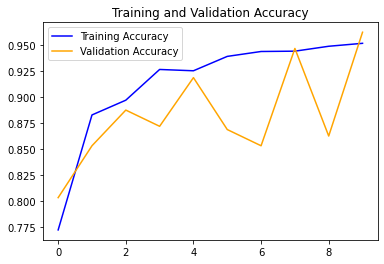

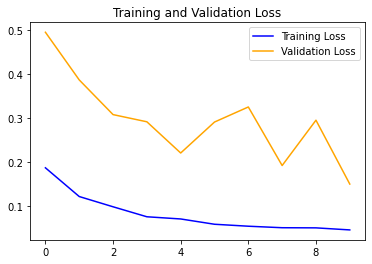

<Figure size 432x288 with 0 Axes>

In [34]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_3)

In [35]:
#Adding the predictions as a variable along with true values
predictions_3 = get_predictions(model_3, validation_generator)

AUC: 0.9887734019227526


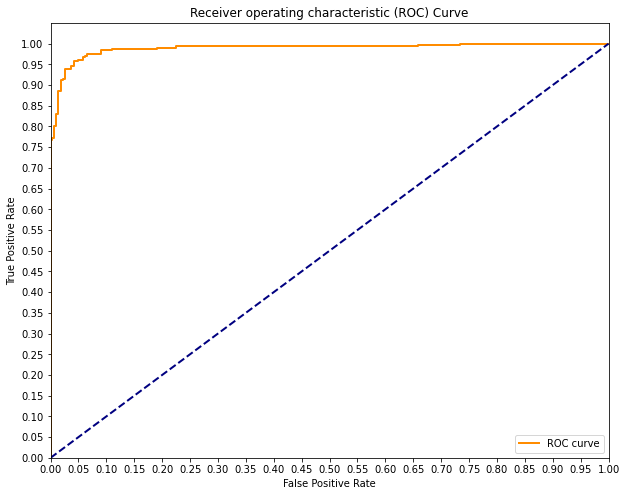

In [36]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_3[0], predictions_3[1])

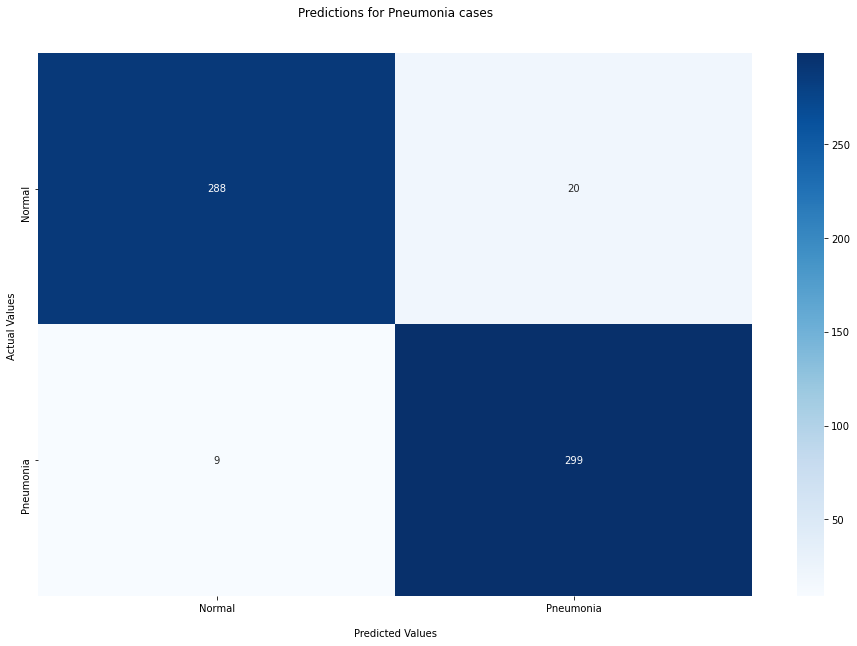

In [37]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_3[0], predictions_3[1])

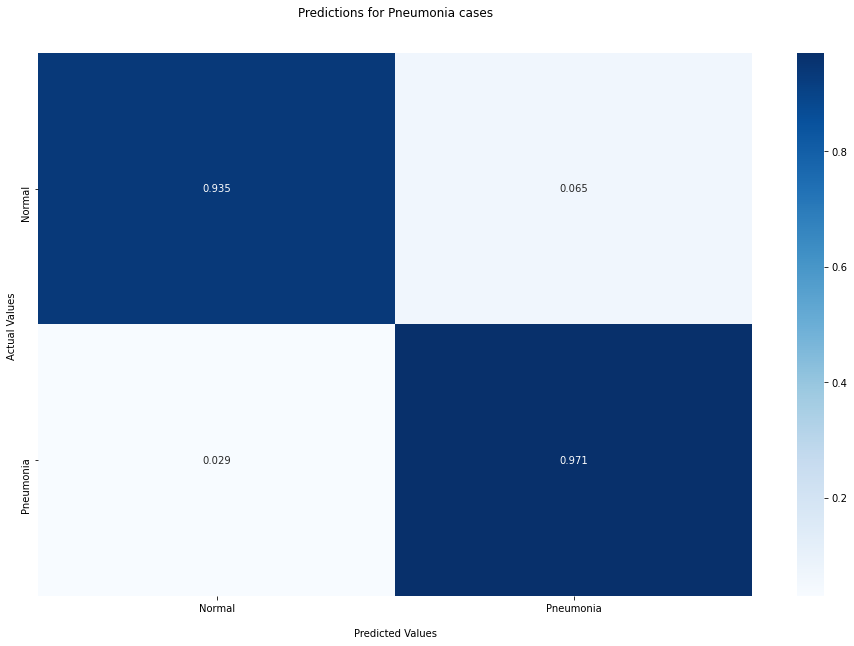

In [38]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_3[0], predictions_3[1])

## Conclusion - Model 3

Model 3 <b>did not perform better</b> than the baseline model in terms of the confusion matrix. Validation accuracy did better than the training accuracy at the end but the fluctuations on the loss and accuracy were pretty heavy. The loss for both the validation set and training set, while not directly parallel, are trending in the same direction. The ROC curve looks very promising with an <b>AUC of ~98.8%</b>. The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>97.1%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>2.9%</b> of the time. Making the adjustments to the best model in the HParams search <b>did not equal</b> better performance for this instance.

## Model 4

Using the best model from HParam search:
* One input CNN layer: Node = 32
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1
* Optimizer = Adam
* Node = 256
* Dropout = 0.1
* Learning rate = 0.0001

Keeping these parameters and adjusting the fit parameters to: 
* Add more epochs: 30 
* Add more validation steps: 20

In [39]:
#Initializing model
model_4 = models.Sequential()

#Adding CNN input layer
model_4.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model_4.add(layers.MaxPooling2D(2,2))
model_4.add(layers.Dropout(0.1))

#Flattening and adding Dense hidden layer
model_4.add(layers.Flatten())
model_4.add(layers.Dense(256, activation = 'relu'))
model_4.add(layers.Dropout(0.1))

#Adding output layer
model_4.add(layers.Dense(1, activation = 'sigmoid'))

#Compiling model
model_4.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [40]:
#Checking model summary to see how many params will be trained
model_4.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 394272)            0         
_________________________________________________________________
dense_52 (Dense)             (None, 256)               100933888 
_________________________________________________________________
dropout_52 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)               

In [41]:
#Fitting model
history_4=model_4.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps 
    epochs=30, #Increasing to 30 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=20) #Increasing to 20 steps

Epoch 1/30
100/100 [==============================] - 66s 660ms/step - loss: 0.1782 - binary_accuracy: 0.8152 - val_loss: 0.1929 - val_binary_accuracy: 0.9221
Epoch 2/30
100/100 [==============================] - 65s 651ms/step - loss: 0.0692 - binary_accuracy: 0.9213 - val_loss: 0.1256 - val_binary_accuracy: 0.9594
Epoch 3/30
100/100 [==============================] - 65s 654ms/step - loss: 0.0467 - binary_accuracy: 0.9497 - val_loss: 0.1034 - val_binary_accuracy: 0.9643
Epoch 4/30
100/100 [==============================] - 65s 647ms/step - loss: 0.0352 - binary_accuracy: 0.9603 - val_loss: 0.0878 - val_binary_accuracy: 0.9708
Epoch 5/30
100/100 [==============================] - 65s 647ms/step - loss: 0.0444 - binary_accuracy: 0.9499 - val_loss: 0.0866 - val_binary_accuracy: 0.9708
Epoch 6/30
100/100 [==============================] - 65s 647ms/step - loss: 0.0289 - binary_accuracy: 0.9666 - val_loss: 0.0710 - val_binary_accuracy: 0.9773
Epoch 7/30
100/100 [==========================

## Evaluation - Model 4

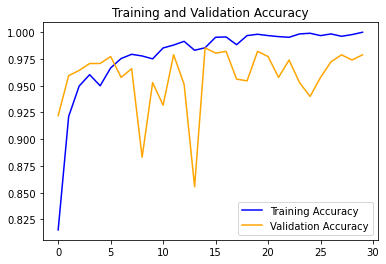

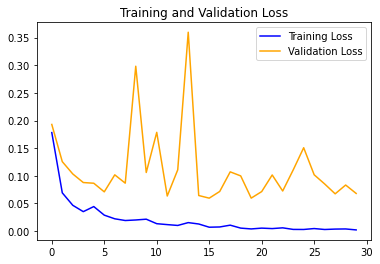

<Figure size 432x288 with 0 Axes>

In [42]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_4)

In [43]:
#Adding the predictions as a variable along with true values
predictions_4 = get_predictions(model_4, validation_generator)

AUC: 0.9964264631472424


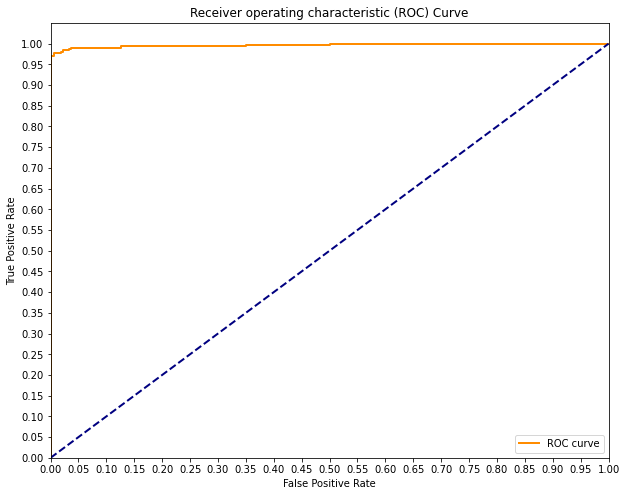

In [44]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_4[0], predictions_4[1])

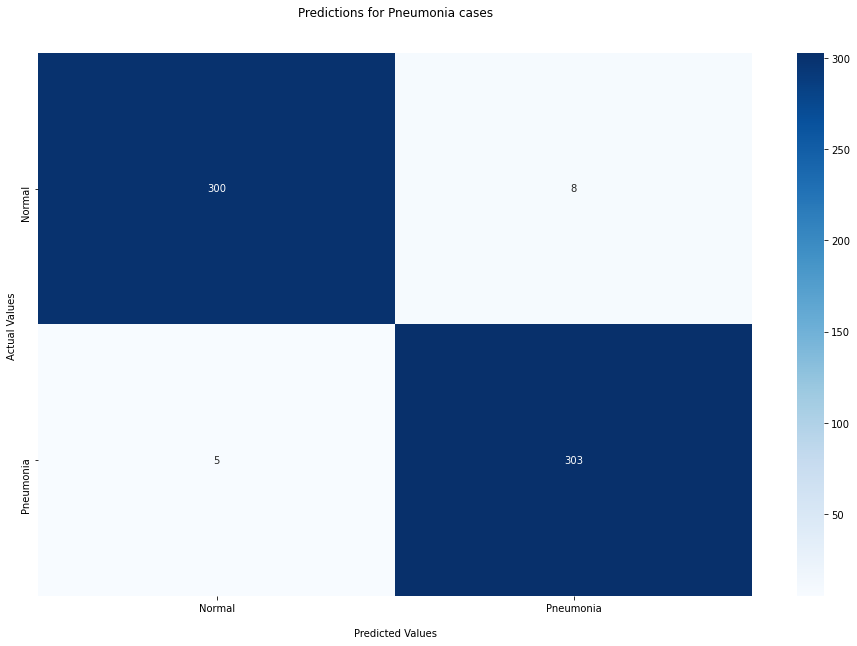

In [45]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_4[0], predictions_4[1])

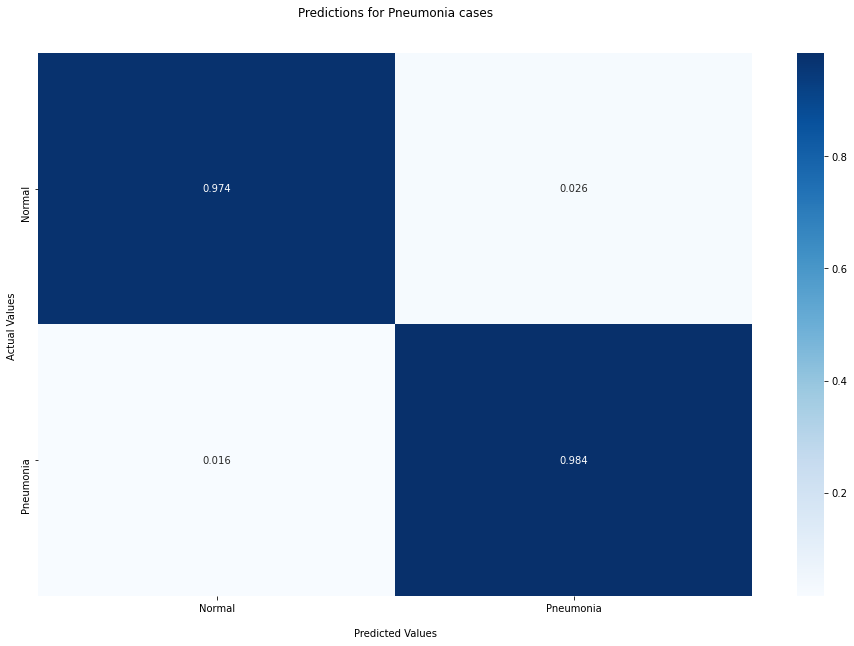

In [46]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_4[0], predictions_4[1])

## Conclusion - Model 4

Model 4 performed better than model 3 in terms of the confusion matrix. The fluctuations on the loss and accuracy are even heavier than the last model. The loss for both the validation set and training set, while not directly parallel, are trending in the same direction. The model does seem to be fairly overfit since the training set outperforms the validation set. The ROC curve shows the model learned extremely quickly and has an <b>AUC of ~99.8%</b>. The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>98.4%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>1.6%</b> of the time. Making the adjustments to previous model <b>did slightly improve</b> the performance compared to the previous model.

## Model 5

Using the best model from HParam search:
* One input CNN layer: Node = 32
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1
* Optimizer = Adam
* Node = 256
* Dropout = 0.1
* Learning rate = 0.0001

Keeping these parameters 
* epochs: 30 
* validation steps: 20
    
Adjusting model with: 
* An additional CNN layer with half nodes
* An additional Dense layer with half nodes



In [47]:
#Initializing model
model_5 = models.Sequential()

#Adding CNN input layer
model_5.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model_5.add(layers.MaxPooling2D(2,2))
model_5.add(layers.Dropout(0.1))

#Adding CNN hidden layer
model_5.add(layers.Conv2D(16, (3,3), activation = 'relu'))
model_5.add(layers.MaxPooling2D(2,2))
model_5.add(layers.Dropout(0.1))

#Flattening and adding Dense hidden layer
model_5.add(layers.Flatten())
model_5.add(layers.Dense(256, activation = 'relu'))
model_5.add(layers.Dropout(0.1))

#Adding Dense hidden layer
model_5.add(layers.Dense(128, activation = 'relu'))
model_5.add(layers.Dropout(0.1))

#Adding output layer
model_5.add(layers.Dense(1, activation = 'sigmoid'))
    
model_5.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [48]:
#Checking model summary to see how many params will be trained
model_5.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 109, 109, 16)      4624      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 54, 54, 16)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 46656)           

In [49]:
#Fitting model
history_5=model_5.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=30, #Keeping 30 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weight to deal with imbalance
    validation_steps=20) #Keeping 20 steps

Epoch 1/30
100/100 [==============================] - 53s 531ms/step - loss: 0.1518 - binary_accuracy: 0.7994 - val_loss: 0.2840 - val_binary_accuracy: 0.8929
Epoch 2/30
100/100 [==============================] - 53s 531ms/step - loss: 0.0703 - binary_accuracy: 0.9178 - val_loss: 0.2141 - val_binary_accuracy: 0.9140
Epoch 3/30
100/100 [==============================] - 53s 531ms/step - loss: 0.0586 - binary_accuracy: 0.9334 - val_loss: 0.2418 - val_binary_accuracy: 0.9058
Epoch 4/30
100/100 [==============================] - 54s 536ms/step - loss: 0.0456 - binary_accuracy: 0.9506 - val_loss: 0.2413 - val_binary_accuracy: 0.8945
Epoch 5/30
100/100 [==============================] - 53s 530ms/step - loss: 0.0450 - binary_accuracy: 0.9484 - val_loss: 0.1723 - val_binary_accuracy: 0.9432
Epoch 6/30
100/100 [==============================] - 53s 533ms/step - loss: 0.0352 - binary_accuracy: 0.9569 - val_loss: 0.1292 - val_binary_accuracy: 0.9610
Epoch 7/30
100/100 [==========================

## Evaluation - Model 5

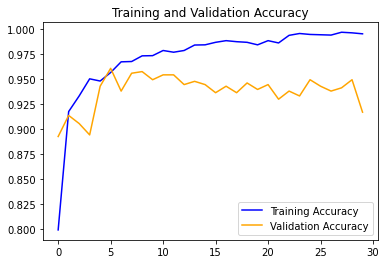

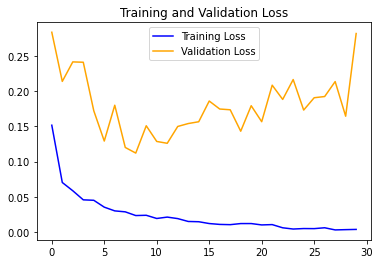

<Figure size 432x288 with 0 Axes>

In [50]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_5)

In [51]:
#Adding the predictions as a variable along with true values
predictions_5 = get_predictions(model_5, validation_generator)

AUC: 0.9844725080114691


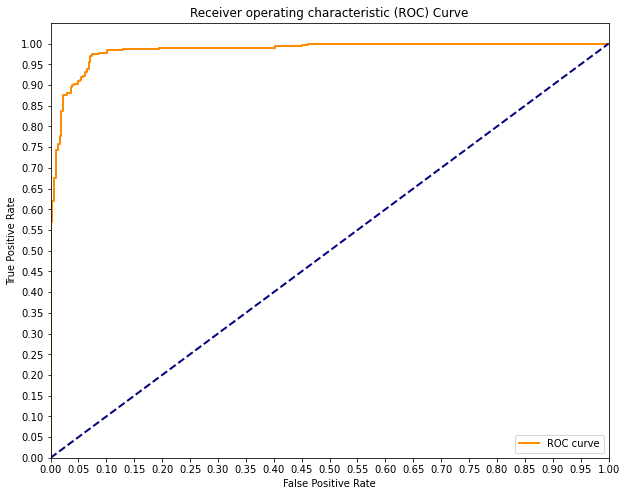

In [52]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_5[0], predictions_5[1])

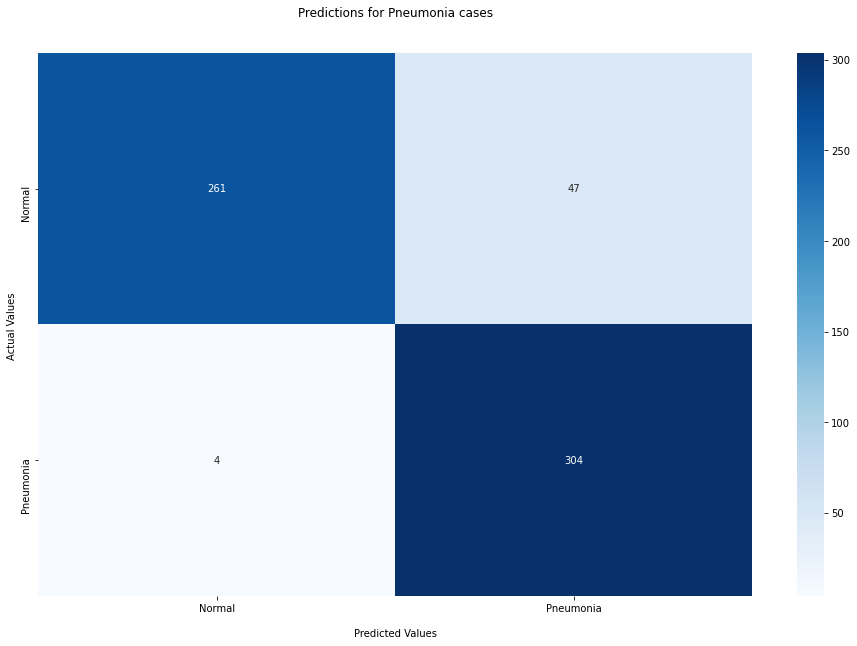

In [53]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_5[0], predictions_5[1])

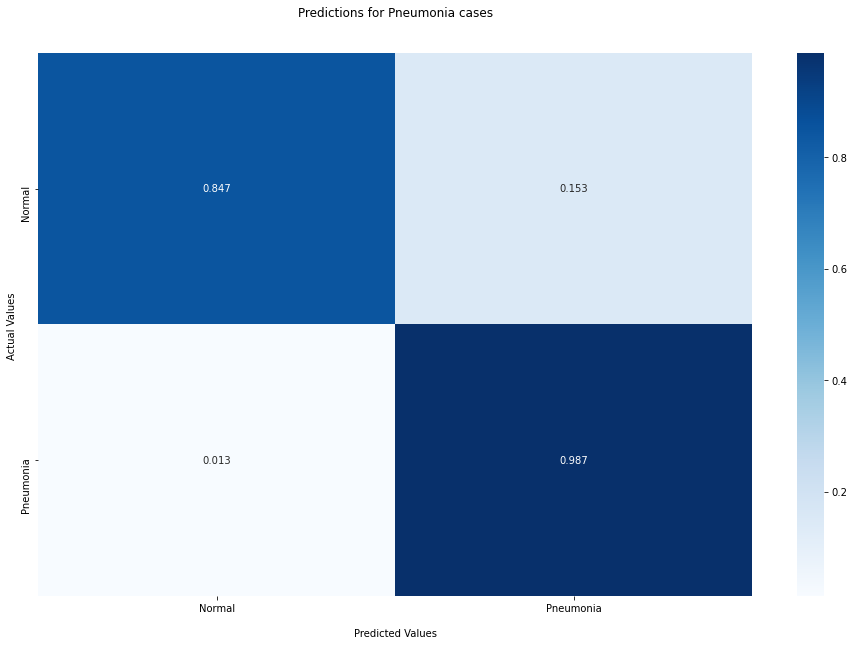

In [54]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_5[0], predictions_5[1])

## Conclusion - Model 5

Model 5 <b>performed better than model 4 in terms of the confusion matrix.</b> The fluctuations on the validation loss are not parallel to the training loss with validation loss seeming to start to trend upwards. The model does seem to be <b>more overfit</b> than the previous model since the training set outperforms the validation set quite heavily. The ROC curve shows the model learned quick but took a little longer than the previous model and has an <b>AUC of ~98.4%</b>. The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>98.7%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>1.3%</b> of the time. Making the adjustments to previous model <b>did slightly improve</b> the performance compared to the previous model <b>but not the evaluation metrics and ROC Curve.</b> This model is a bit unstable compared to the others.

## Model 6

Using the best model from HParam search:
* One CNN layer: Node = 32
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1
* Optimizer = Adam
* Node = 256
* Dropout = 0.1
* Learning rate = 0.0001

Keeping these parameters 
* epochs: 30 
* validation steps: 20
    
Adjusting model with: 
* A new input CNN layer with double nodes
* An additional CNN layer with half nodes
* An additional Dense layer with half nodes
* An additional Dense layer with double nodes

In [55]:
#Initializing model
model_6 = models.Sequential()

#Adding CNN input layer
model_6.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model_6.add(layers.MaxPooling2D(2,2))
model_6.add(layers.Dropout(0.1))

#Adding CNN hidden layer
model_6.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model_6.add(layers.MaxPooling2D(2,2))
model_6.add(layers.Dropout(0.1))

#Adding CNN hidden layer
model_6.add(layers.Conv2D(16, (3,3), activation = 'relu'))
model_6.add(layers.MaxPooling2D(2,2))
model_6.add(layers.Dropout(0.1))

#Flattening and adding Dense hidden layer
model_6.add(layers.Flatten())
model_6.add(layers.Dense(256, activation = 'relu'))
model_6.add(layers.Dropout(0.1))

#Adding Dense hidden layer
model_6.add(layers.Dense(128, activation = 'relu'))
model_6.add(layers.Dropout(0.1))

#Adding Dense hidden layer
model_6.add(layers.Dense(64, activation = 'relu'))
model_6.add(layers.Dropout(0.1))

#Adding output layer
model_6.add(layers.Dense(1, activation = 'sigmoid'))
    
#Compiling model
model_6.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [56]:
#Checking model summary to see how many params will be trained
model_6.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 52, 52, 16)      

In [57]:
#Fitting model
history_6=model_6.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=50, #Increasing to 50 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=20) #Keeping 20 steps

Epoch 1/50
100/100 [==============================] - 85s 850ms/step - loss: 0.2043 - binary_accuracy: 0.7412 - val_loss: 0.4896 - val_binary_accuracy: 0.7549
Epoch 2/50
100/100 [==============================] - 84s 845ms/step - loss: 0.1009 - binary_accuracy: 0.8841 - val_loss: 0.3394 - val_binary_accuracy: 0.8425
Epoch 3/50
100/100 [==============================] - 84s 845ms/step - loss: 0.0736 - binary_accuracy: 0.9207 - val_loss: 0.2307 - val_binary_accuracy: 0.9058
Epoch 4/50
100/100 [==============================] - 85s 846ms/step - loss: 0.0645 - binary_accuracy: 0.9285 - val_loss: 0.2293 - val_binary_accuracy: 0.9107
Epoch 5/50
100/100 [==============================] - 84s 844ms/step - loss: 0.0567 - binary_accuracy: 0.9358 - val_loss: 0.1940 - val_binary_accuracy: 0.9302
Epoch 6/50
100/100 [==============================] - 85s 849ms/step - loss: 0.0493 - binary_accuracy: 0.9416 - val_loss: 0.2638 - val_binary_accuracy: 0.8880
Epoch 7/50
100/100 [==========================

## Evaluation - Model 6

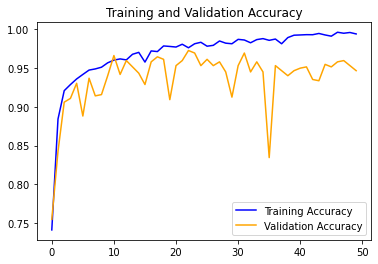

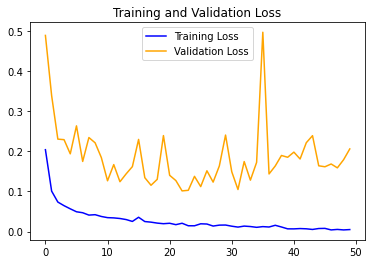

<Figure size 432x288 with 0 Axes>

In [58]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_6)

In [59]:
#Adding the predictions as a variable along with true values
predictions_6 = get_predictions(model_6, validation_generator)

AUC: 0.9925419547984482


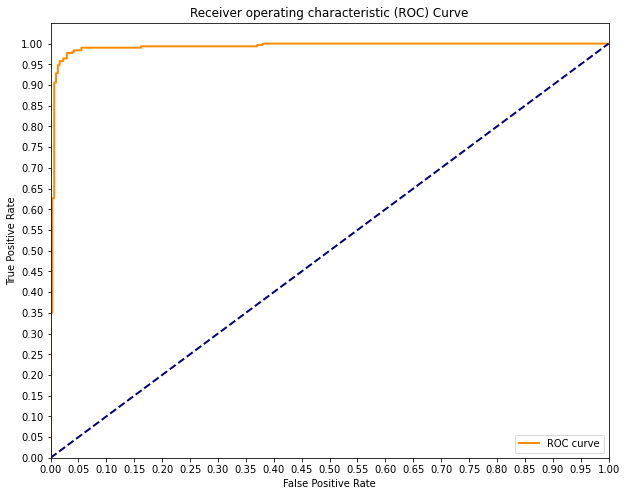

In [60]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_6[0], predictions_6[1])

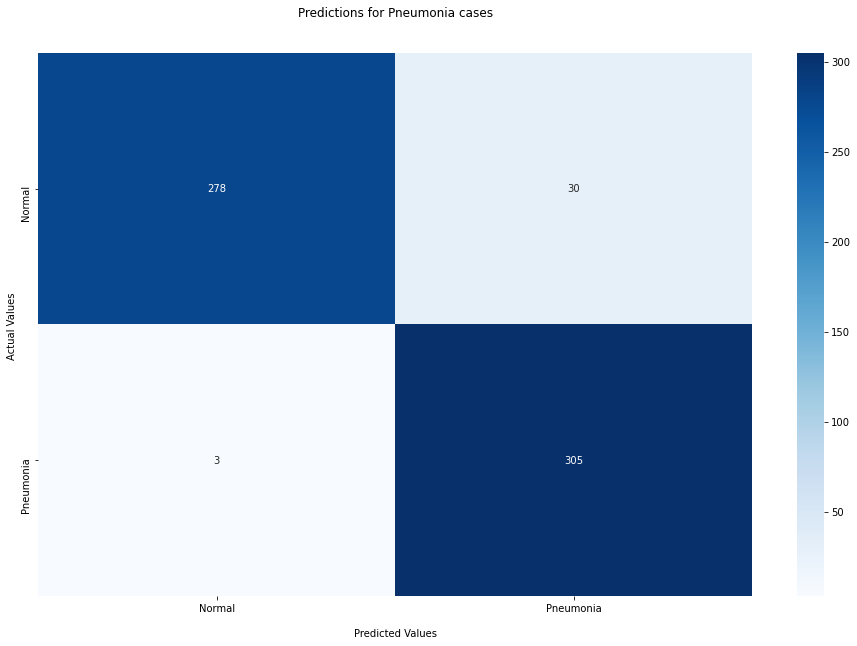

In [61]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_6[0], predictions_6[1])

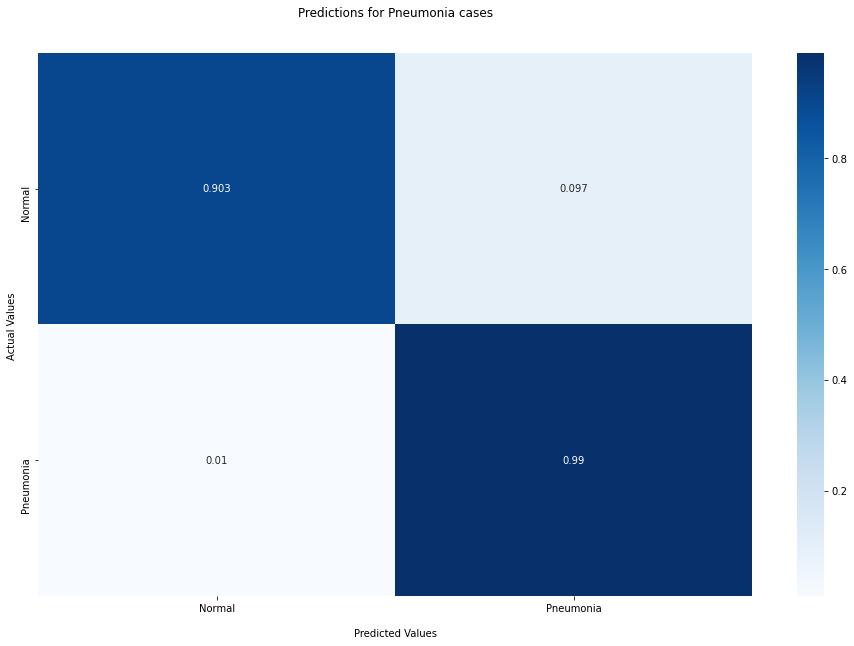

In [62]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_6[0], predictions_6[1])

## Conclusion - Model 6

<b>Model 6 is the best performing model up this point in terms of the confusion matrix.</b> The fluctuations on the validation loss and accuracy are extremely heavy. The model does seem to be overfit since the training set outperforms the validation set quite heavily. The ROC curve shows the model learned quick has an <b>AUC of ~99.2%.</b> The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>99%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>1%</b> of the time. Making the adjustments to the pervious model <b>did slightly improve</b> the performance compared to the previous model <b>but not the evaluation metrics and ROC Curve.</b> This model is a bit unstable.

## Model 7 - Transfer Learning

Using the ResNet50 model with:
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1

Keeping this parameter 
* validation steps: 20

Adding:
* epochs = 50

In [63]:
#Initializing model
model_7 = models.Sequential()

#Adding pretrained resnet50 model to a variable
pretrained_model_resnet50= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224, 224, 3),
                   pooling='avg',classes=1,
                   weights='imagenet')
for layer in pretrained_model_resnet50.layers:
        layer.trainable=False

#Adding pretrained model as a layer 
model_7.add(pretrained_model_resnet50)

In [64]:
#Flattening layer and adding Dense hidden layer
model_7.add(layers.Flatten())
model_7.add(layers.Dense(256, activation='relu'))

#Adding output layer
model_7.add(layers.Dense(1, activation='sigmoid'))

In [65]:
#Checking model summary to see how many params will be trained
model_7.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_29 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 257       
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [66]:
#Compiling model
model_7.compile(optimizer=optimizers.Adam(lr=0.001),
                     loss='binary_crossentropy',
                     metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

#Fitting model
history_7 = model_7.fit(train_generator, #Using train data
                             steps_per_epoch=100, #Keeping 100 steps
                             validation_data=validation_generator, #Using validation data
                             class_weight = class_weight, #Adding weights to deal with imbalance
                             epochs=50, #Keeping 50 epochs
                             validation_steps=20 #Keeping 25 steps
                          )

Epoch 1/50
100/100 [==============================] - 90s 897ms/step - loss: 0.2325 - binary_accuracy: 0.6178 - val_loss: 0.5879 - val_binary_accuracy: 0.6721
Epoch 2/50
100/100 [==============================] - 90s 904ms/step - loss: 0.1907 - binary_accuracy: 0.7431 - val_loss: 0.4652 - val_binary_accuracy: 0.8214
Epoch 3/50
100/100 [==============================] - 91s 911ms/step - loss: 0.1789 - binary_accuracy: 0.7651 - val_loss: 0.4264 - val_binary_accuracy: 0.8393
Epoch 4/50
100/100 [==============================] - 91s 909ms/step - loss: 0.1595 - binary_accuracy: 0.8119 - val_loss: 0.4818 - val_binary_accuracy: 0.8279
Epoch 5/50
100/100 [==============================] - 90s 903ms/step - loss: 0.1527 - binary_accuracy: 0.8142 - val_loss: 0.3795 - val_binary_accuracy: 0.8295
Epoch 6/50
100/100 [==============================] - 91s 906ms/step - loss: 0.1411 - binary_accuracy: 0.8306 - val_loss: 0.4428 - val_binary_accuracy: 0.8571
Epoch 7/50
100/100 [==========================

## Evaluation - Model 7

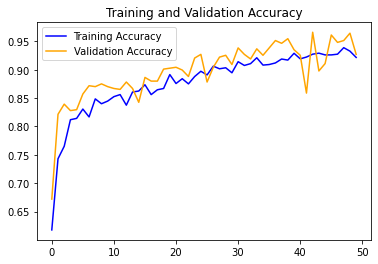

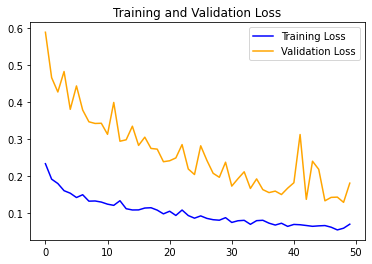

<Figure size 432x288 with 0 Axes>

In [67]:
#Evaluating the loss and accuracy of the model
evaluate_nn(history_7)

In [68]:
#Adding the predictions as a variable along with true values
predictions_7 = get_predictions(model_7, validation_generator)

AUC: 0.9916722887502109


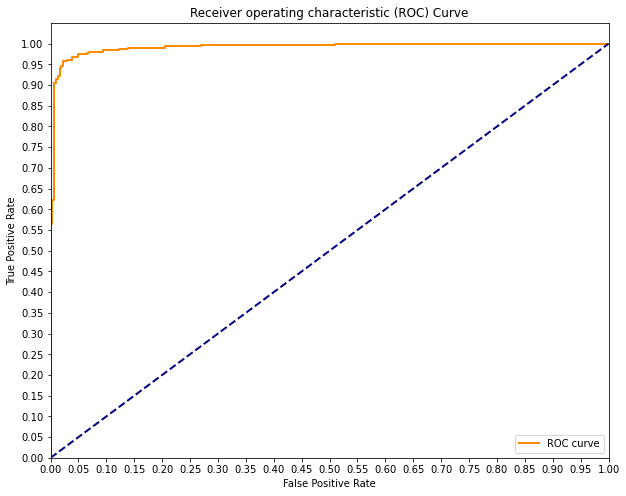

In [69]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_7[0], predictions_7[1])

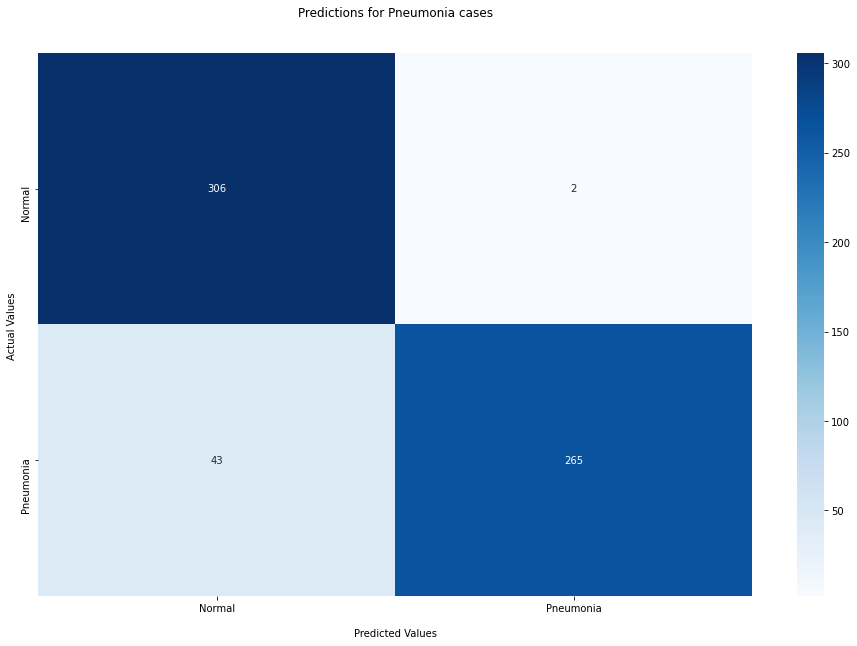

In [70]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_7[0], predictions_7[1])

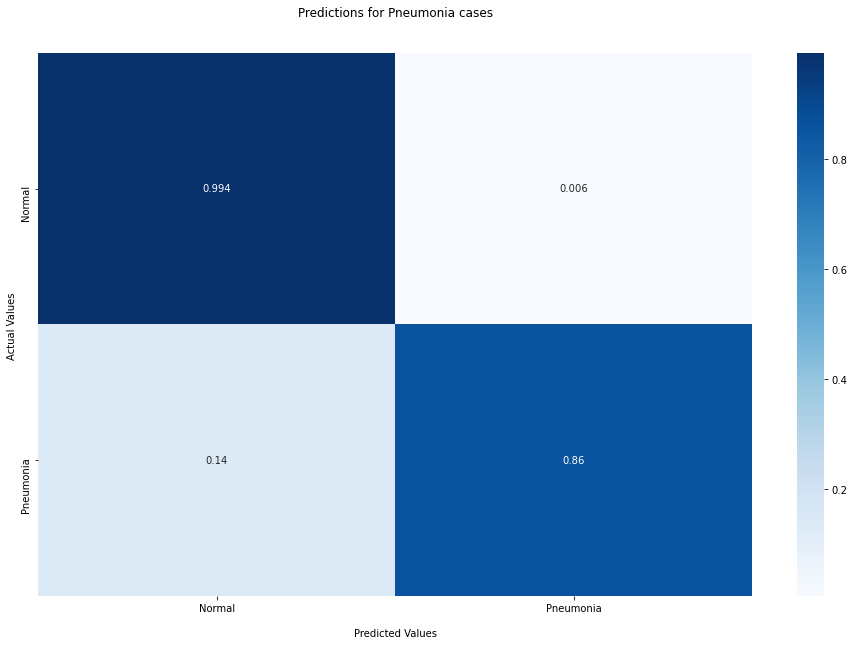

In [71]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_7[0], predictions_7[1])

## Conclusion - Model 7

<b>Model 7 used transfer learning</b> but was not the best performing model up this point in terms of the confusion matrix. The fluctuations on the validation loss and accuracy are happening but not as aggressively. </b>The model does seem to be overfitting</b> in terms of the loss but validation score at the end of the training was better than the training score.. The ROC curve shows the model learned quick has an <b>AUC of ~99.1%</b>. The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>86%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>14%</b> of the time. Making the adjustments to the pervious model <b>did not improve</b> the performance compared to the previous model but not the evaluation metrics and ROC Curve. This model seems a bit more stable as the epochs increase.

## Model 8 - Transfer Learning Resnet50 - Tuning

In [72]:
#Initializing model
model_8 = models.Sequential()

#Adding pretrained resnet50 model to a variable
pretrained_model_resnet50_tuned= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224, 224, 3),
                   pooling='avg',classes=1,
                   weights='imagenet')

# Freeze all layers except for the
for layer in pretrained_model_resnet50_tuned.layers[:-11]:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(pretrained_model_resnet50_tuned.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [73]:
#Adding pretrained model as a layer
model_8.add(pretrained_model_resnet50_tuned)

#Flattening layer and adding Dense hidden layer
model_8.add(layers.Flatten())
model_8.add(layers.Dense(256, activation='relu'))
model_8.add(layers.Dropout(0.2))

#Adding output layer
model_8.add(layers.Dense(1, activation='sigmoid'))

In [74]:
model_8.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_30 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 257       
Total params: 24,112,513
Trainable params: 4,990,465
Non-trainable params: 19,122,048
_________________________________________________________________


In [75]:
#Compiling model
model_8.compile(optimizer=optimizers.Adam(lr=1e-4),
                     loss='binary_crossentropy',
                     metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

#Fitting model
history_8 = model_8.fit(train_generator, #Using train data
                             steps_per_epoch=100, #Keeping 100 steps
                             validation_data=validation_generator, #Using validation data
                             class_weight = class_weight, #Adding weights to deal with imbalance
                             epochs=20, #lowering to 20 epochs
                             validation_steps=20) #Keeping 20 steps

Epoch 1/20
100/100 [==============================] - 106s 1s/step - loss: 0.0975 - binary_accuracy: 0.8838 - val_loss: 0.9195 - val_binary_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 106s 1s/step - loss: 0.0471 - binary_accuracy: 0.9499 - val_loss: 1.6227 - val_binary_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 106s 1s/step - loss: 0.0461 - binary_accuracy: 0.9468 - val_loss: 0.3713 - val_binary_accuracy: 0.8377
Epoch 4/20
100/100 [==============================] - 105s 1s/step - loss: 0.0351 - binary_accuracy: 0.9631 - val_loss: 1.4158 - val_binary_accuracy: 0.5097
Epoch 5/20
100/100 [==============================] - 105s 1s/step - loss: 0.0286 - binary_accuracy: 0.9678 - val_loss: 0.2004 - val_binary_accuracy: 0.9269
Epoch 6/20
100/100 [==============================] - 105s 1s/step - loss: 0.0330 - binary_accuracy: 0.9622 - val_loss: 1.3091 - val_binary_accuracy: 0.5536
Epoch 7/20
100/100 [==============================] - 105s

## Evaluation - Model 8

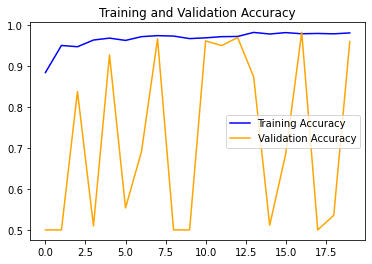

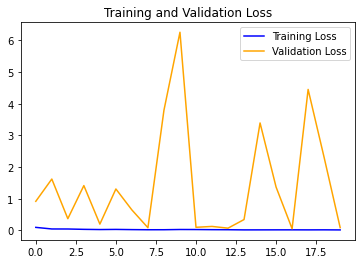

<Figure size 432x288 with 0 Axes>

In [76]:
evaluate_nn(history_8)

In [77]:
#Adding the predictions as a variable along with true values
predictions_8 = get_predictions(model_8, validation_generator)

AUC: 0.998186878057008


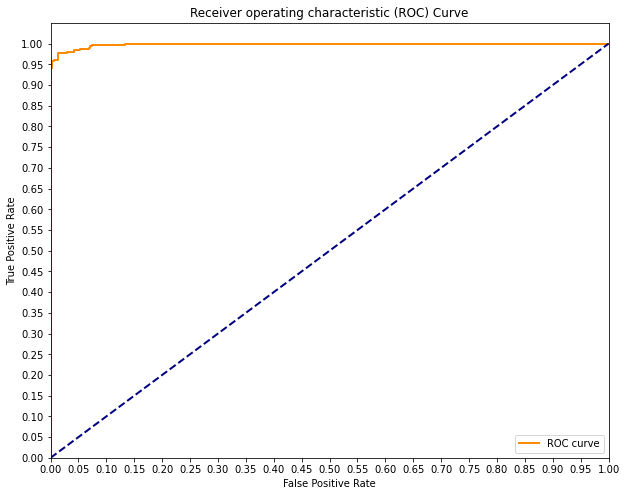

In [78]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_8[0], predictions_8[1])

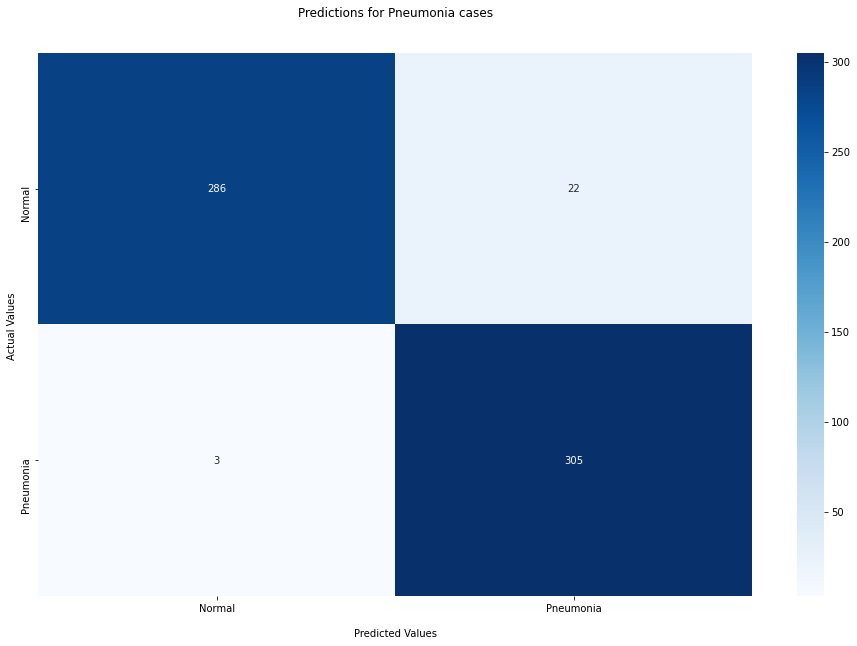

In [79]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_8[0], predictions_8[1])

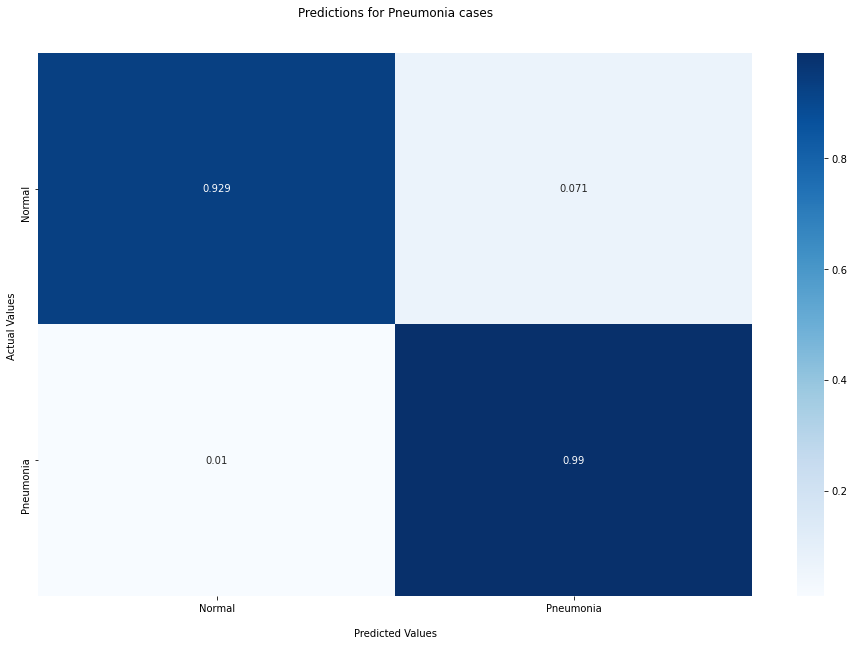

In [80]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_8[0], predictions_8[1])

## Conclusion - Model 8

<b>Model 8 tuned the transfer learning model and is tied as one of the best performing model up this point in terms of the confusion matrix.</b> The fluctuations on the validation loss and accuracy are extremely aggressive. The model is not heavily overfit at the end of the training. The ROC curve shows the model learned quick has an <b>AUC of ~99.8%.</b> The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>99%,</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>1%</b> of the time. Making the adjustments to the pervious model <b>significantly improved</b> the performance compared to the previous model but not the evaluation metrics. This model seems very unstable as it progressed through the epochs.

## Model 9 - Data Augmentation

Using the ResNet50 model with:
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1

Keeping these parameters
* epochs = 50
* validation steps: 20

Adding:
* Data Augmentation to the generators


In [81]:
#Creating augmented train data 
train_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

#Creating train generator with augmented train data
train_generator_aug = train_datagen_aug.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

#Creating augmented validation data
val_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

##Creating validation generator with augmented validation data
validation_generator_aug = val_datagen_aug.flow_from_directory(validation_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      class_mode = 'binary')


#Fitting resnet50 model to augmented data
history_9 = model_8.fit(
    train_generator_aug, #Using augmented train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=50, #Keeping 50 epochs
    validation_data=validation_generator_aug, #Using augmented validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=20) #Keeping 20 steps

Found 4616 images belonging to 2 classes.
Found 616 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 119s 1s/step - loss: 0.1541 - binary_accuracy: 0.8145 - val_loss: 1.3404 - val_binary_accuracy: 0.5130
Epoch 2/50
100/100 [==============================] - 119s 1s/step - loss: 0.1222 - binary_accuracy: 0.8504 - val_loss: 1.4474 - val_binary_accuracy: 0.5130
Epoch 3/50
100/100 [==============================] - 119s 1s/step - loss: 0.1215 - binary_accuracy: 0.8325 - val_loss: 0.3205 - val_binary_accuracy: 0.8718
Epoch 4/50
100/100 [==============================] - 122s 1s/step - loss: 0.1048 - binary_accuracy: 0.8716 - val_loss: 0.5406 - val_binary_accuracy: 0.6916
Epoch 5/50
100/100 [==============================] - 119s 1s/step - loss: 0.1133 - binary_accuracy: 0.8558 - val_loss: 0.3018 - val_binary_accuracy: 0.8831
Epoch 6/50
100/100 [==============================] - 119s 1s/step - loss: 0.1072 - binary_accuracy: 0.8627 - val_loss: 0.2900 - val

## Evaluation - Model 9

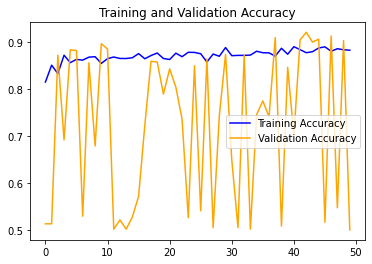

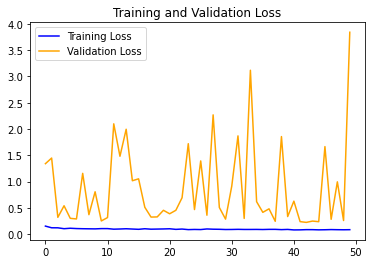

<Figure size 432x288 with 0 Axes>

In [82]:
evaluate_nn(history_9)

In [83]:
#Adding the predictions as a variable along with true values
predictions_9 = get_predictions(model_8, validation_generator_aug)

AUC: 0.9480361359419801


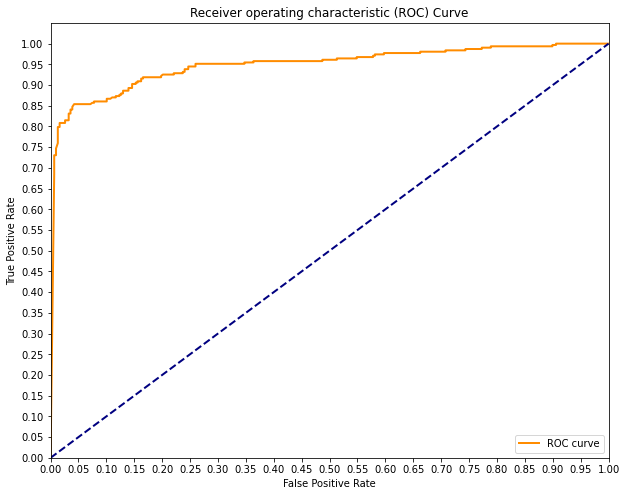

In [84]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_9[0], predictions_9[1])

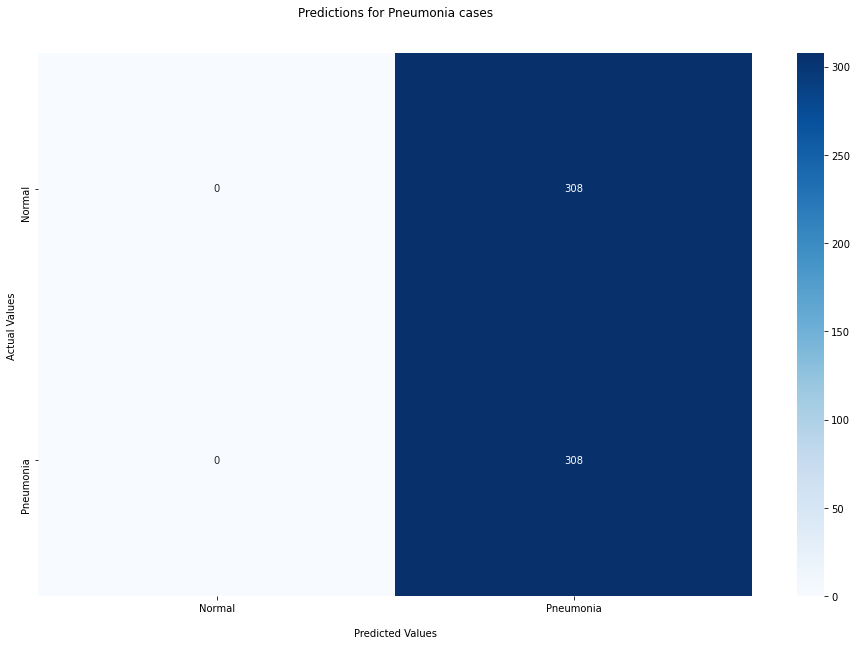

In [85]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_9[0], predictions_9[1])

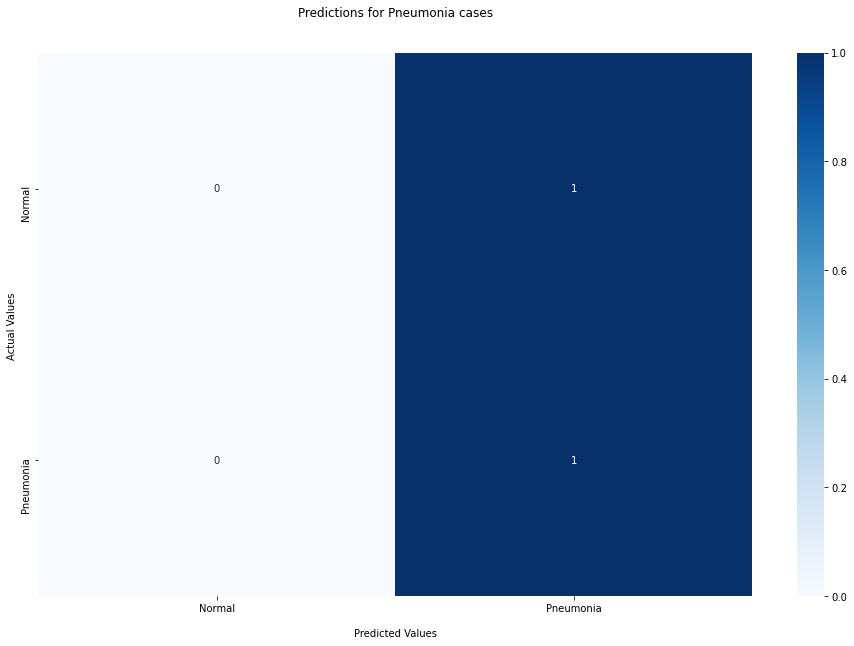

In [86]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_9[0], predictions_9[1])

## Conclusion - Model 9

<b>Model 9 used a data augmentation and was the worst performing model up until this point.</b> The fluctuations on the validation loss and accuracy are extremely aggressive. The model is very overfit at the end of training. The ROC curve shows the model has a bit of a struggle but has an <b>AUC of ~94.8%.</b> The model is not predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>100%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>0%</b> of the time. Making the adjustments to the pervious model <b>did not significantly improve</b> the performance compared to the previous model. <b>This model seems very unstable as it progressed through the epochs and only chose the majority class.</b>

## Model 10

Using baseline model:
* One input CNN layer: Node = 32
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1
* Optimizer = RMSProp
* Learning rate = 1e-4

With this model, it will be adjusted with: 
* Different regularizer = L2(0.001)

In [87]:
from tensorflow.keras import regularizers

#Initializing model
model_10 = models.Sequential()

#Adding CNN input layer with L2
model_10.add(layers.Conv2D(32, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (224, 224, 3)))
model_10.add(layers.MaxPooling2D(2,2))

#Flattening and adding Dense layer with L2
model_10.add(layers.Flatten())
model_10.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

#Adding output layer
model_10.add(layers.Dense(1, activation = 'sigmoid'))
    
model_10.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.RMSprop(lr=1e-4), 
metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))
    

In [88]:
#Checking model summary to see how many params will be trained
model_10.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 394272)            0         
_________________________________________________________________
dense_65 (Dense)             (None, 256)               100933888 
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 257       
Total params: 100,935,041
Trainable params: 100,935,041
Non-trainable params: 0
_________________________________________________________________


In [89]:
#Fitting model to regular generated data
history_10 = model_10.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=50, #Keeping 50 epochs
    validation_data=validation_generator, #Using validation generator
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=20) #Keeping 20 steps

Epoch 1/50
100/100 [==============================] - 94s 941ms/step - loss: 0.5478 - binary_accuracy: 0.6219 - val_loss: 1.1911 - val_binary_accuracy: 0.5357
Epoch 2/50
100/100 [==============================] - 92s 924ms/step - loss: 0.1692 - binary_accuracy: 0.8203 - val_loss: 0.2653 - val_binary_accuracy: 0.9042
Epoch 3/50
100/100 [==============================] - 92s 916ms/step - loss: 0.1231 - binary_accuracy: 0.8775 - val_loss: 0.2670 - val_binary_accuracy: 0.8977
Epoch 4/50
100/100 [==============================] - 92s 918ms/step - loss: 0.1038 - binary_accuracy: 0.9147 - val_loss: 0.2133 - val_binary_accuracy: 0.9205
Epoch 5/50
100/100 [==============================] - 92s 918ms/step - loss: 0.0960 - binary_accuracy: 0.9175 - val_loss: 0.2067 - val_binary_accuracy: 0.9302
Epoch 6/50
100/100 [==============================] - 92s 919ms/step - loss: 0.0847 - binary_accuracy: 0.9331 - val_loss: 0.2420 - val_binary_accuracy: 0.9026
Epoch 7/50
100/100 [==========================

## Evaluation - Model 10

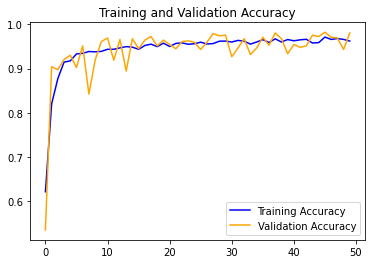

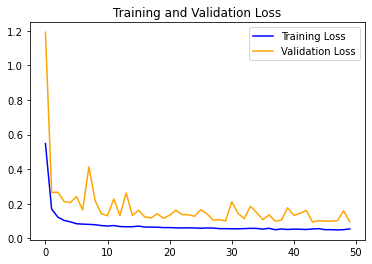

<Figure size 432x288 with 0 Axes>

In [90]:
evaluate_nn(history_10)

In [91]:
#Adding the predictions as a variable along with true values
predictions_10 = get_predictions(model_10, validation_generator)

AUC: 0.9957307303086524


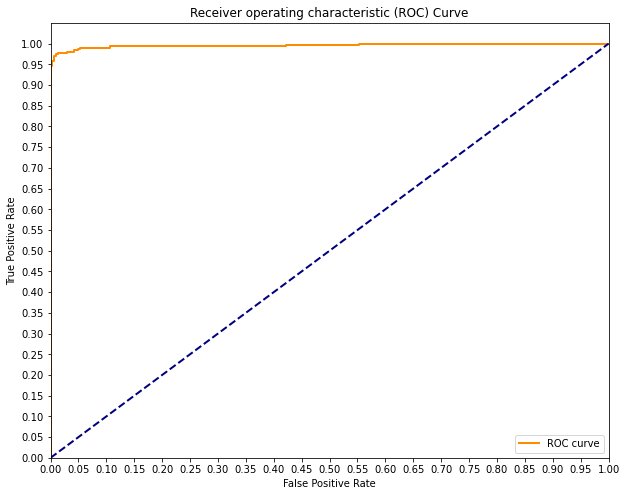

In [92]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_10[0], predictions_10[1])

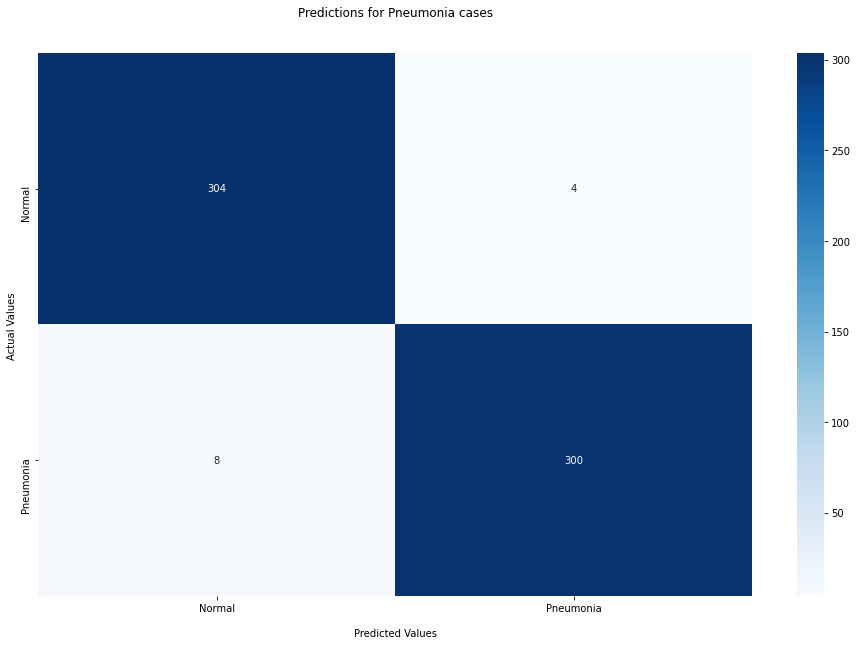

In [93]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_10[0], predictions_10[1])

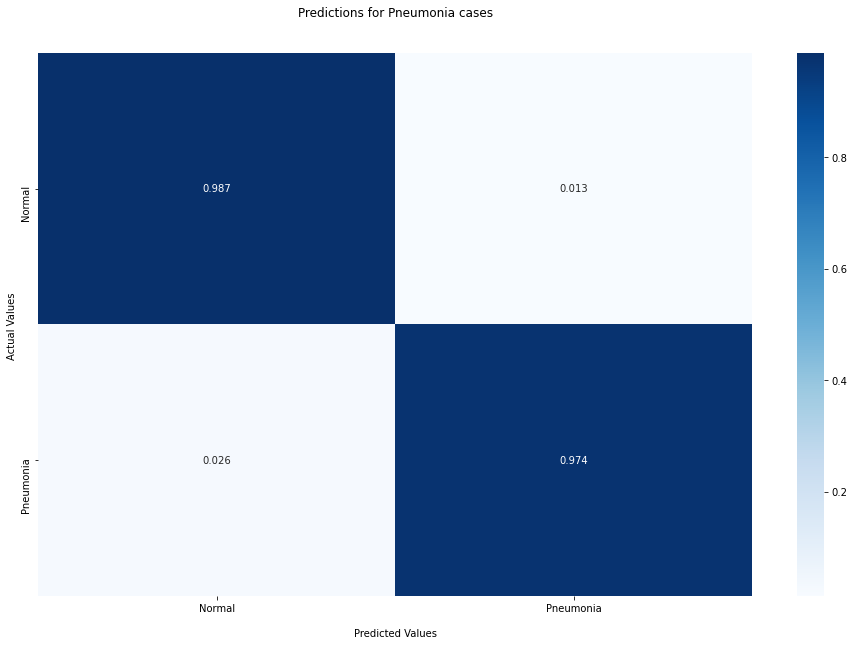

In [94]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_10[0], predictions_10[1])

## Conclusion - Model 10

<b>Model 10 used tuned based on the baseline model but using a different regularization method. (l2 regularization)</b> The fluctuations on the validation loss and accuracy are fairly stable. The validation accuracy did outperform the train accuracy at the end of the training and the loss for the training and validation data are fairly close. The ROC curve shows the model learned very quickly and has an <b>AUC of ~99.5%.</b> The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>97.4%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>2.6%</b> of the time. Going back to the baseline model <b>significantly improved</b> the performance compared to the previous model. This model seems more stable as it progressed through the epochs.

## Model 11

Using baseline model:
* One CNN layer: Node = 32
* One Dense hidden layer: Node = 256
* One Dense output layer: Node = 1
* Optimizer = RMSProp
* Learning rate = 1e-4

Keeping: 
* Different regularizer = L2(0.001)

With this model, it will be adjusted with: 
* A new input CNN layer with double nodes
* An additional CNN layer with half nodes
* An additional Dense layer with half nodes
* An additional Dense layer with quarter nodes
* L2 regularizer for each new layer

In [95]:
#Initializing model
model_11 = models.Sequential()

#Adding CNN input layer with L2
model_11.add(layers.Conv2D(64, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (224, 224, 3)))
model_11.add(layers.MaxPooling2D(2,2))

#Adding CNN layer with L2
model_11.add(layers.Conv2D(32, (3,3), kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
model_11.add(layers.MaxPooling2D(2,2))

#Adding CNN layer with L2
model_11.add(layers.Conv2D(16, (3,3), kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))
model_11.add(layers.MaxPooling2D(2,2))

#Flattening and adding Dense layer with L2
model_11.add(layers.Flatten())
model_11.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

#Adding Dense layer with L2
model_11.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

#Adding Dense layer with L2
model_11.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation = 'relu'))

#Adding output layer
model_11.add(layers.Dense(1, activation = 'sigmoid'))

#Compiling model
model_11.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr=1e-4), 
metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [96]:
#Checking model summary to see how many params will be trained
model_11.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 52, 52, 16)        4624      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 26, 26, 16)        0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 10816)           

In [97]:
#Fitting model
history_11 = model_11.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=50, #Keeping 50 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=20)#Keeping 20 steps

Epoch 1/50
100/100 [==============================] - 70s 698ms/step - loss: 0.8197 - binary_accuracy: 0.6304 - val_loss: 0.8155 - val_binary_accuracy: 0.8458
Epoch 2/50
100/100 [==============================] - 71s 708ms/step - loss: 0.4988 - binary_accuracy: 0.8938 - val_loss: 0.6658 - val_binary_accuracy: 0.8555
Epoch 3/50
100/100 [==============================] - 70s 703ms/step - loss: 0.3792 - binary_accuracy: 0.9377 - val_loss: 0.4124 - val_binary_accuracy: 0.9627
Epoch 4/50
100/100 [==============================] - 71s 708ms/step - loss: 0.3198 - binary_accuracy: 0.9538 - val_loss: 0.4255 - val_binary_accuracy: 0.9334
Epoch 5/50
100/100 [==============================] - 70s 702ms/step - loss: 0.2945 - binary_accuracy: 0.9490 - val_loss: 0.3292 - val_binary_accuracy: 0.9675
Epoch 6/50
100/100 [==============================] - 70s 705ms/step - loss: 0.2553 - binary_accuracy: 0.9647 - val_loss: 0.3392 - val_binary_accuracy: 0.9513
Epoch 7/50
100/100 [==========================

## Evaluation - Model 11

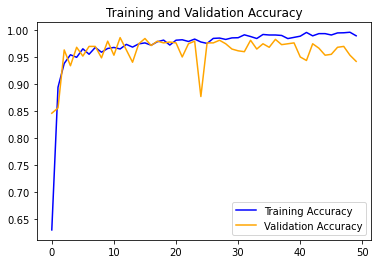

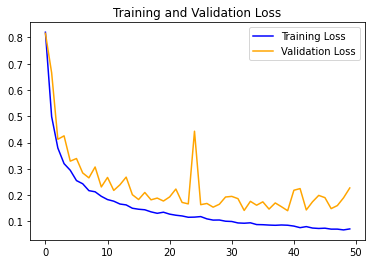

<Figure size 432x288 with 0 Axes>

In [98]:
evaluate_nn(history_11)

In [99]:
#Adding the predictions as a variable along with true values
predictions_11 = get_predictions(model_11, validation_generator)

AUC: 0.9947820037105752


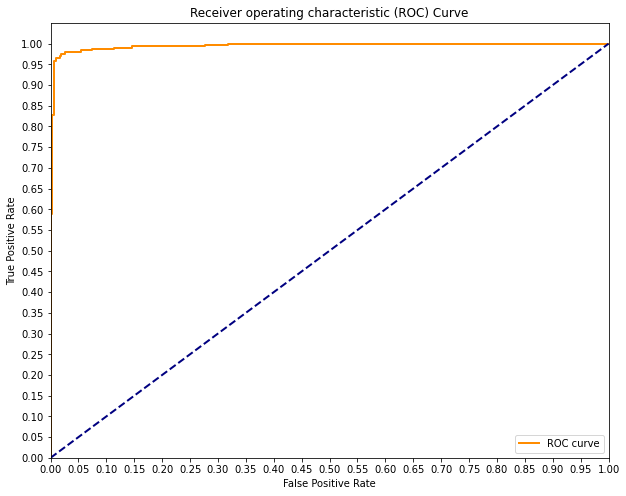

In [100]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_11[0], predictions_11[1])

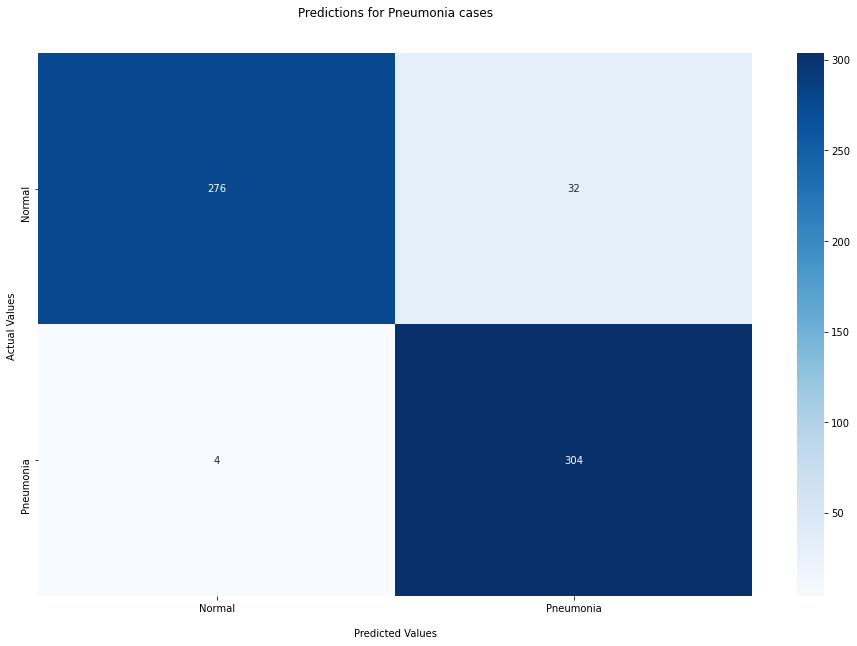

In [101]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_11[0], predictions_11[1])

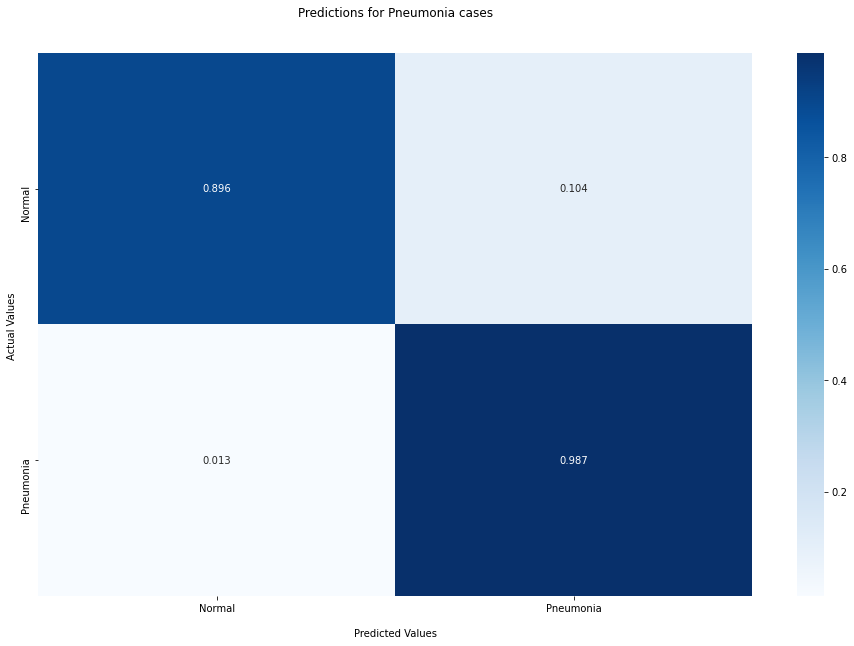

In [102]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_11[0], predictions_11[1])

## Conclusion - Model 11

Model 11 further using tuning by adding more layers to the baseline with the new regularization method. (l2 regularization) The fluctuations on the validation loss and accuracy are fairly stable but not as stable as the previous model. The model seems to be a little overfit for the both the loss and accuracy. The ROC curve shows the model learned very quickly and has an <b>AUC of ~99.4%.</b> The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>98.7%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>1.3%</b> of the time. The model <b>did perform better with the confusion matrix</b> on the validation data compared to the previous model <b>but did not outperform on the loss and validation accuracy visualization.</b>

## Model 12 - Transfer Learning VGG19

In [103]:
model_12 = models.Sequential()

pretrained_model_vgg = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet',
    classes=1,
)
for layer in pretrained_model_vgg.layers:
        layer.trainable=False
        
#Adding pretrained model as a layer 
model_12.add(pretrained_model_vgg)

In [104]:
#Flattening layer and adding Dense hidden layer
model_12.add(layers.GlobalAveragePooling2D())
model_12.add(layers.Dense(128, activation='relu'))
model_12.add(layers.Dropout(0.2))


#Adding output layer
model_12.add(layers.Dense(1, activation='sigmoid'))

In [105]:
#Checking model summary to see how many params will be trained
model_12.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_64 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 129       
Total params: 20,090,177
Trainable params: 65,793
Non-trainable params: 20,024,384
_________________________________________________________________


In [106]:
#Compiling model
model_12.compile(optimizer=optimizers.Adam(lr=5e-4),
                     loss='binary_crossentropy',
                     metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

#Fitting model
history_12 = model_12.fit(train_generator, #Using train data
                             steps_per_epoch=100, #Keeping 100 steps
                             validation_data=validation_generator, #Using validation data
                             class_weight = class_weight, #Adding weights to deal with imbalance
                             epochs=20, #lowering to 20 epochs
                             validation_steps=20 #Keeping 20 steps
                          )

Epoch 1/20
100/100 [==============================] - 246s 2s/step - loss: 0.1889 - binary_accuracy: 0.7415 - val_loss: 0.4198 - val_binary_accuracy: 0.8734
Epoch 2/20
100/100 [==============================] - 249s 2s/step - loss: 0.1327 - binary_accuracy: 0.8481 - val_loss: 0.3329 - val_binary_accuracy: 0.8718
Epoch 3/20
100/100 [==============================] - 249s 2s/step - loss: 0.1138 - binary_accuracy: 0.8624 - val_loss: 0.2959 - val_binary_accuracy: 0.8847
Epoch 4/20
100/100 [==============================] - 249s 2s/step - loss: 0.1019 - binary_accuracy: 0.8794 - val_loss: 0.2885 - val_binary_accuracy: 0.8880
Epoch 5/20
100/100 [==============================] - 247s 2s/step - loss: 0.0971 - binary_accuracy: 0.8804 - val_loss: 0.2503 - val_binary_accuracy: 0.8994
Epoch 6/20
100/100 [==============================] - 247s 2s/step - loss: 0.0886 - binary_accuracy: 0.8958 - val_loss: 0.2288 - val_binary_accuracy: 0.9042
Epoch 7/20
100/100 [==============================] - 247s

## Evaluation - Model 12

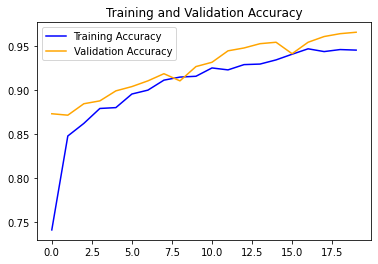

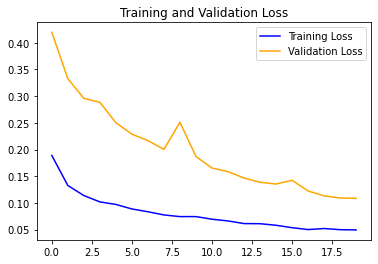

<Figure size 432x288 with 0 Axes>

In [107]:
evaluate_nn(history_12)

In [108]:
#Adding the predictions as a variable along with true values
predictions_12 = get_predictions(model_12, validation_generator)

AUC: 0.99425493337831


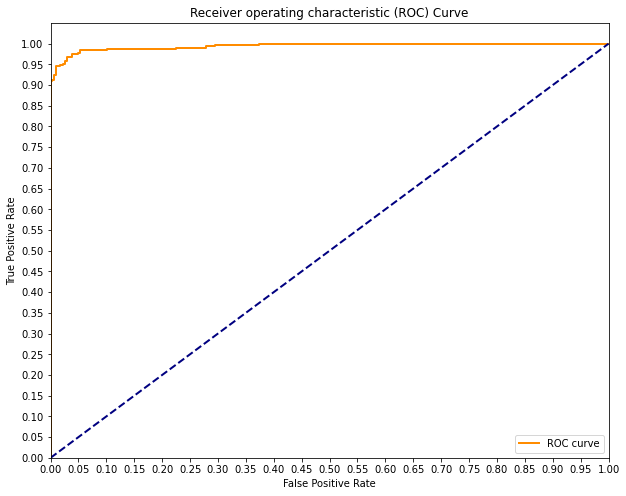

In [109]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_12[0], predictions_12[1])

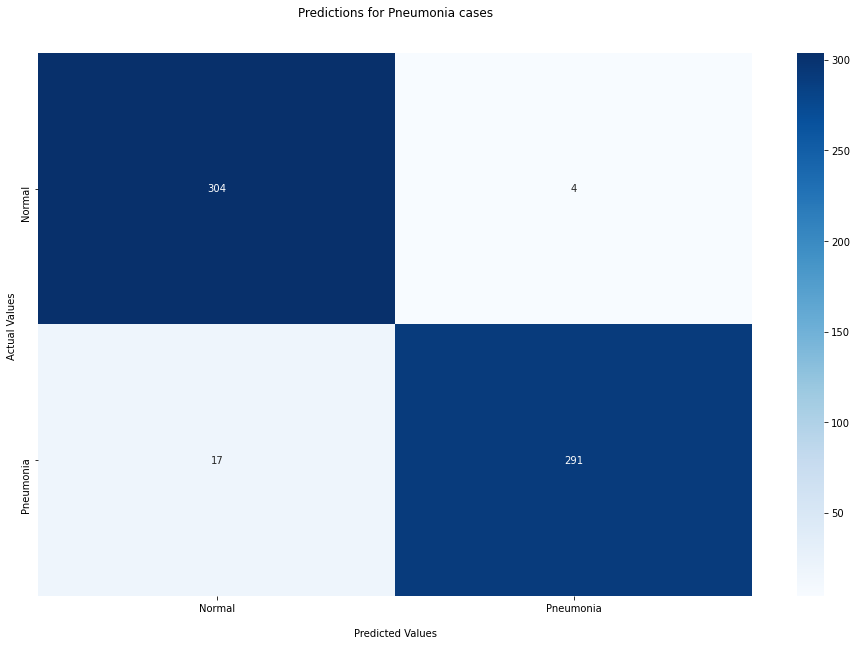

In [110]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_12[0], predictions_12[1])

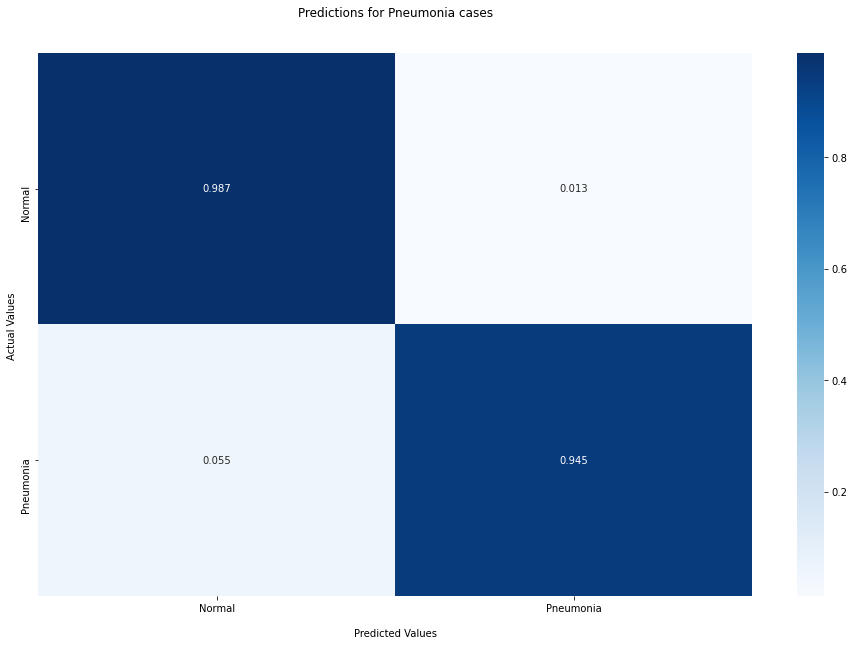

In [111]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_12[0], predictions_12[1])

## Conclusion - Model 12

<b>Model 12 used a different transfer learning model called VGG19.</b> The fluctuations on the validation loss and accuracy are not aggressive. The model seems to be a little overfit on the loss and but performed better on validation data for accuracy. The ROC curve shows the model learned very quickly and had an <b>AUC of ~99.4%.</b> The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>94.5%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>5.5%</b> of the time. The model <b>did not perform better with the confusion matrix</b> on the validation data compared to the previous model but both the loss and accuracy in the visualization are trending the right direction.

## Model 13 - Transfer Learning VGG19 - Tuning

In [112]:
model_13 = models.Sequential()

pretrained_model_vgg19_tuned = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    classes=1,
)
# Freeze all layers except for the
for layer in pretrained_model_vgg19_tuned.layers[:-5]:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(pretrained_model_vgg19_tuned.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [113]:
#Adding pretrained model as a layer 
model_13.add(pretrained_model_vgg19_tuned)

#Flattening layer and adding Dense hidden layer
model_13.add(layers.GlobalAveragePooling2D())
model_13.add(layers.Dense(128, activation='relu'))
model_13.add(layers.Dropout(0.2))


#Adding output layer
model_13.add(layers.Dense(1, activation='sigmoid'))

In [114]:
model_13.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_65 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 129       
Total params: 20,090,177
Trainable params: 9,505,025
Non-trainable params: 10,585,152
_________________________________________________________________


In [115]:
#Compiling model
model_13.compile(optimizer=optimizers.Adam(lr=5e-4),
                     loss='binary_crossentropy',
                     metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

#Fitting model
history_13 = model_13.fit(train_generator, #Using train data
                             steps_per_epoch=100, #Keeping 100 steps
                             validation_data=validation_generator, #Using validation data
                             class_weight = class_weight, #Adding weights to deal with imbalance
                             epochs=20, #Keeping 20 epochs
                             validation_steps=20 #Keeping 20 steps
                          )

Epoch 1/20
100/100 [==============================] - 300s 3s/step - loss: 0.1680 - binary_accuracy: 0.7491 - val_loss: 0.1942 - val_binary_accuracy: 0.9497
Epoch 2/20
100/100 [==============================] - 301s 3s/step - loss: 0.0555 - binary_accuracy: 0.9367 - val_loss: 0.0733 - val_binary_accuracy: 0.9756
Epoch 3/20
100/100 [==============================] - 303s 3s/step - loss: 0.0309 - binary_accuracy: 0.9631 - val_loss: 0.0709 - val_binary_accuracy: 0.9789
Epoch 4/20
100/100 [==============================] - 303s 3s/step - loss: 0.0319 - binary_accuracy: 0.9653 - val_loss: 0.0608 - val_binary_accuracy: 0.9756
Epoch 5/20
100/100 [==============================] - 304s 3s/step - loss: 0.0230 - binary_accuracy: 0.9758 - val_loss: 0.0447 - val_binary_accuracy: 0.9821
Epoch 6/20
100/100 [==============================] - 313s 3s/step - loss: 0.0188 - binary_accuracy: 0.9794 - val_loss: 0.0547 - val_binary_accuracy: 0.9821
Epoch 7/20
100/100 [==============================] - 303s

## Evaluation - Model 13

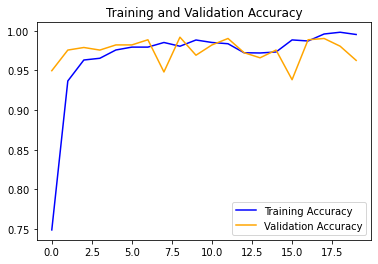

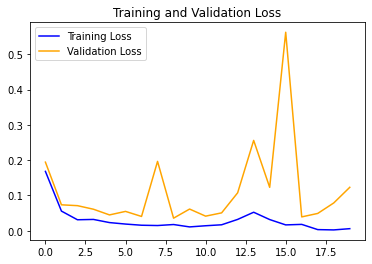

<Figure size 432x288 with 0 Axes>

In [116]:
evaluate_nn(history_13)

In [117]:
#Adding the predictions as a variable along with true values
predictions_13 = get_predictions(model_13, validation_generator)

AUC: 0.9980076741440378


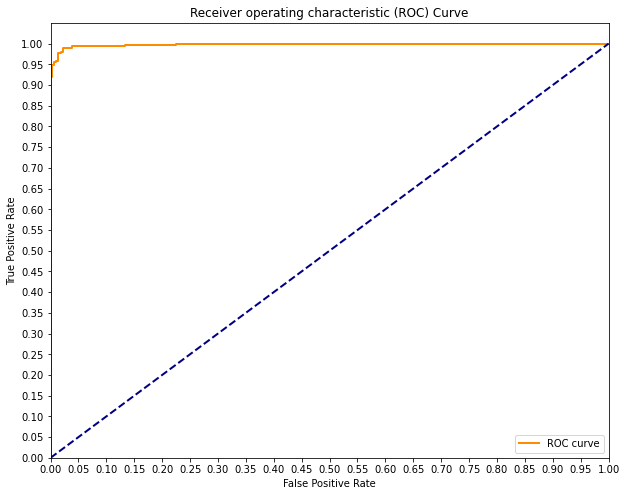

In [118]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_13[0], predictions_13[1])

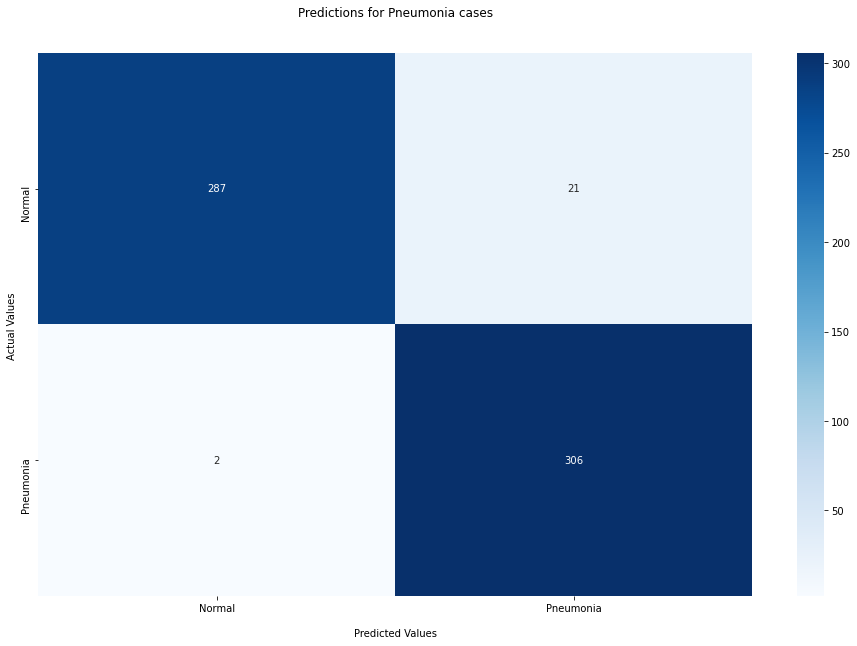

In [119]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_13[0], predictions_13[1])

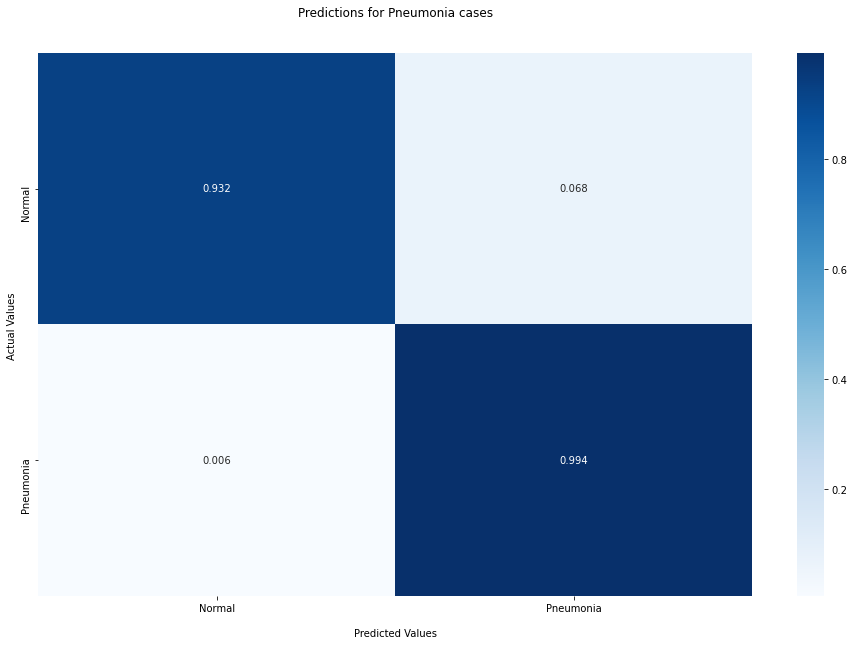

In [120]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_13[0], predictions_13[1])

## Conclusion - Model 13

Model 12 tuned the previous VGG19 model and is the best performing model up until this point in terms of the confusion matrix on validation data. The fluctuations on the validation loss and accuracy are not aggressive. The model <b>seems to be a little overfit on the loss</b> and <b>but performed better on validation data for accuracy.</b> The ROC curve shows the model learned very quickly and had an AUC of <b>~99.4%.</b> The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>94.5%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>5.5%</b> of the time. The model <b>was not as stable as it could have been</b> as it was going through the epochs.

## Model 14 - Transfer Learning Resnet152V2

In [121]:
#https://www.kaggle.com/code/jonaspalucibarbosa/chest-x-ray-pneumonia-cnn-transfer-learning

model_14 = models.Sequential()

pretrained_model_resnet152 = tf.keras.applications.resnet_v2.ResNet152V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

for layer in pretrained_model_resnet152.layers:
        layer.trainable=False
        
#Adding pretrained model as a layer 
model_14.add(pretrained_model_resnet152)

model_14.add(layers.GlobalAveragePooling2D())
model_14.add(layers.Dense(128, activation='relu'))
model_14.add(layers.Dropout(0.1))
    
#Final Layer (Output)
model_14.add(layers.Dense(1, activation='sigmoid'))

In [122]:
model_14.compile(loss='binary_crossentropy', 
                        optimizer = optimizers.Adam(learning_rate=5e-5), 
                        metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

model_14.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_66 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
_________________________________________________________________


In [123]:
history_14 = model_14.fit(train_generator, #Using train data
                             steps_per_epoch=100, #Keeping 100 steps
                             validation_data=validation_generator, #Using validation data
                             class_weight = class_weight, #Adding weights to deal with imbalance
                             epochs= 20, #keeping to 20 epochs
                             validation_steps=20) #Keeping 20 steps

Epoch 1/20
100/100 [==============================] - 234s 2s/step - loss: 0.1777 - binary_accuracy: 0.7806 - val_loss: 0.2548 - val_binary_accuracy: 0.9156
Epoch 2/20
100/100 [==============================] - 241s 2s/step - loss: 0.0803 - binary_accuracy: 0.9118 - val_loss: 0.1901 - val_binary_accuracy: 0.9269
Epoch 3/20
100/100 [==============================] - 237s 2s/step - loss: 0.0638 - binary_accuracy: 0.9272 - val_loss: 0.1637 - val_binary_accuracy: 0.9351
Epoch 4/20
100/100 [==============================] - 232s 2s/step - loss: 0.0537 - binary_accuracy: 0.9411 - val_loss: 0.1469 - val_binary_accuracy: 0.9399
Epoch 5/20
100/100 [==============================] - 235s 2s/step - loss: 0.0495 - binary_accuracy: 0.9496 - val_loss: 0.1345 - val_binary_accuracy: 0.9464
Epoch 6/20
100/100 [==============================] - 237s 2s/step - loss: 0.0433 - binary_accuracy: 0.9528 - val_loss: 0.1260 - val_binary_accuracy: 0.9464
Epoch 7/20
100/100 [==============================] - 238s

## Evaluation - Model 14

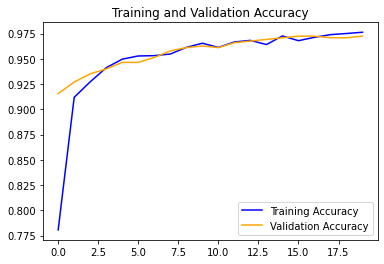

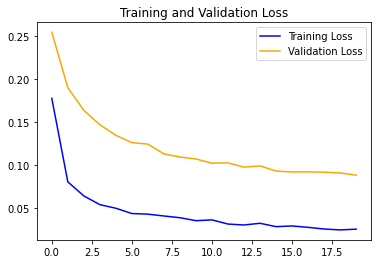

<Figure size 432x288 with 0 Axes>

In [124]:
evaluate_nn(history_14)

In [125]:
#Adding the predictions as a variable along with true values
predictions_14 = get_predictions(model_14, validation_generator)

AUC: 0.9949085005903189


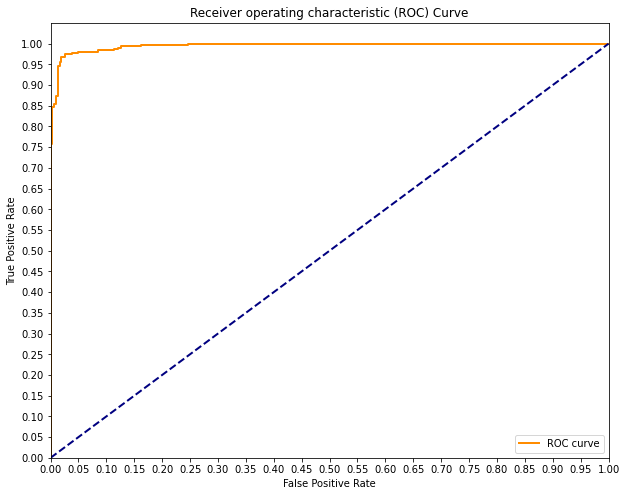

In [126]:
#Plotting ROC-AUC curve
plot_roc_auc(predictions_14[0], predictions_14[1])

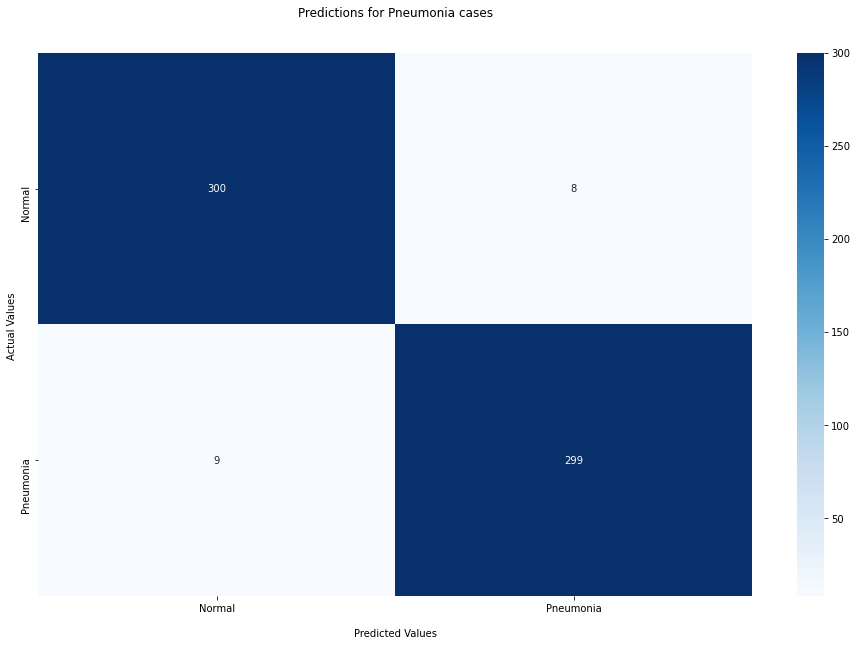

In [127]:
#Plotting confusion matrix with counts
plot_confusion_matrix(predictions_14[0], predictions_14[1])

In [128]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(predictions_14[0], predictions_14[1])

## Conclusion - Model 14

Model 16 used a different transfer learning model called Resnet152V2. The fluctuations on the validation loss and accuracy are <b>the most minimal of all of the models</b> The model seems to be a overfit on the loss and but performed better on validation data for accuracy. The ROC curve shows the model learned very quickly and had an <b>AUC of ~99.4%.</b> The model is predicting the information very well. The model predicted Pneumonia for Pneumonia X-rays <b>97.1%</b> of the time on the validation data and predicted Normal on Pneumonia X-rays <b>2.9%</b> of the time. The model <b>did not perform better</b> with the confusion matrix on the validation data compared to the previous model but both the loss and accuracy are <b>the closest we have gotten so far through the epochs.</b>

## Final Model Evaluations

For this model evaluation, 3 models were chosen to be used on the test set:

* Model 10: Due to it's stability on the evaluation accuracy and validation metrics, it will be evaluated on the test set.
* Model 13: Due to it's confusion matrix predictions on the validation set, it will be evaluated on the test set.
* Model 14: Due to it's stability on the evaluation accuracy and validation metrics, it will be evaluated on the test set.

In [130]:
#Scaling test data
test_datagen = ImageDataGenerator(rescale = 1./255)

#Creating a generator for test data
test_generator = test_datagen.flow_from_directory(test_directory,
                                                   target_size = (224, 224),
                                                   batch_size=32,
                                                   class_mode = 'binary')


Found 624 images belonging to 2 classes.


### Final Test Prediction

In [131]:
#Checking the classification of the information
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

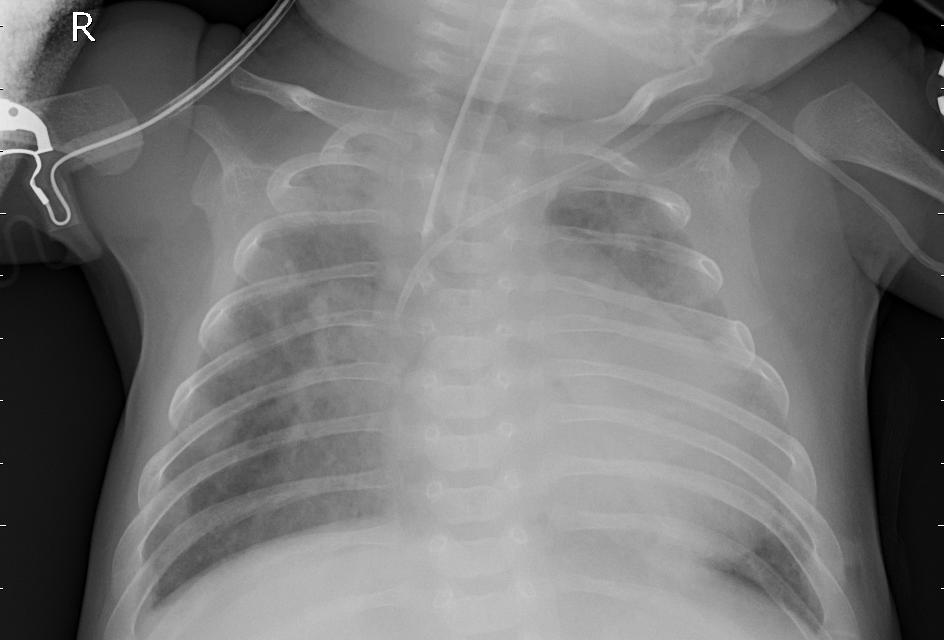

In [132]:
from tensorflow.keras.preprocessing import image

#Displaying a photo of a pneumonia picture from the test set
img_path_pn = "data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"
Load_image_pn = tf.keras.preprocessing.image.load_img(img_path_pn)
Load_image_pn

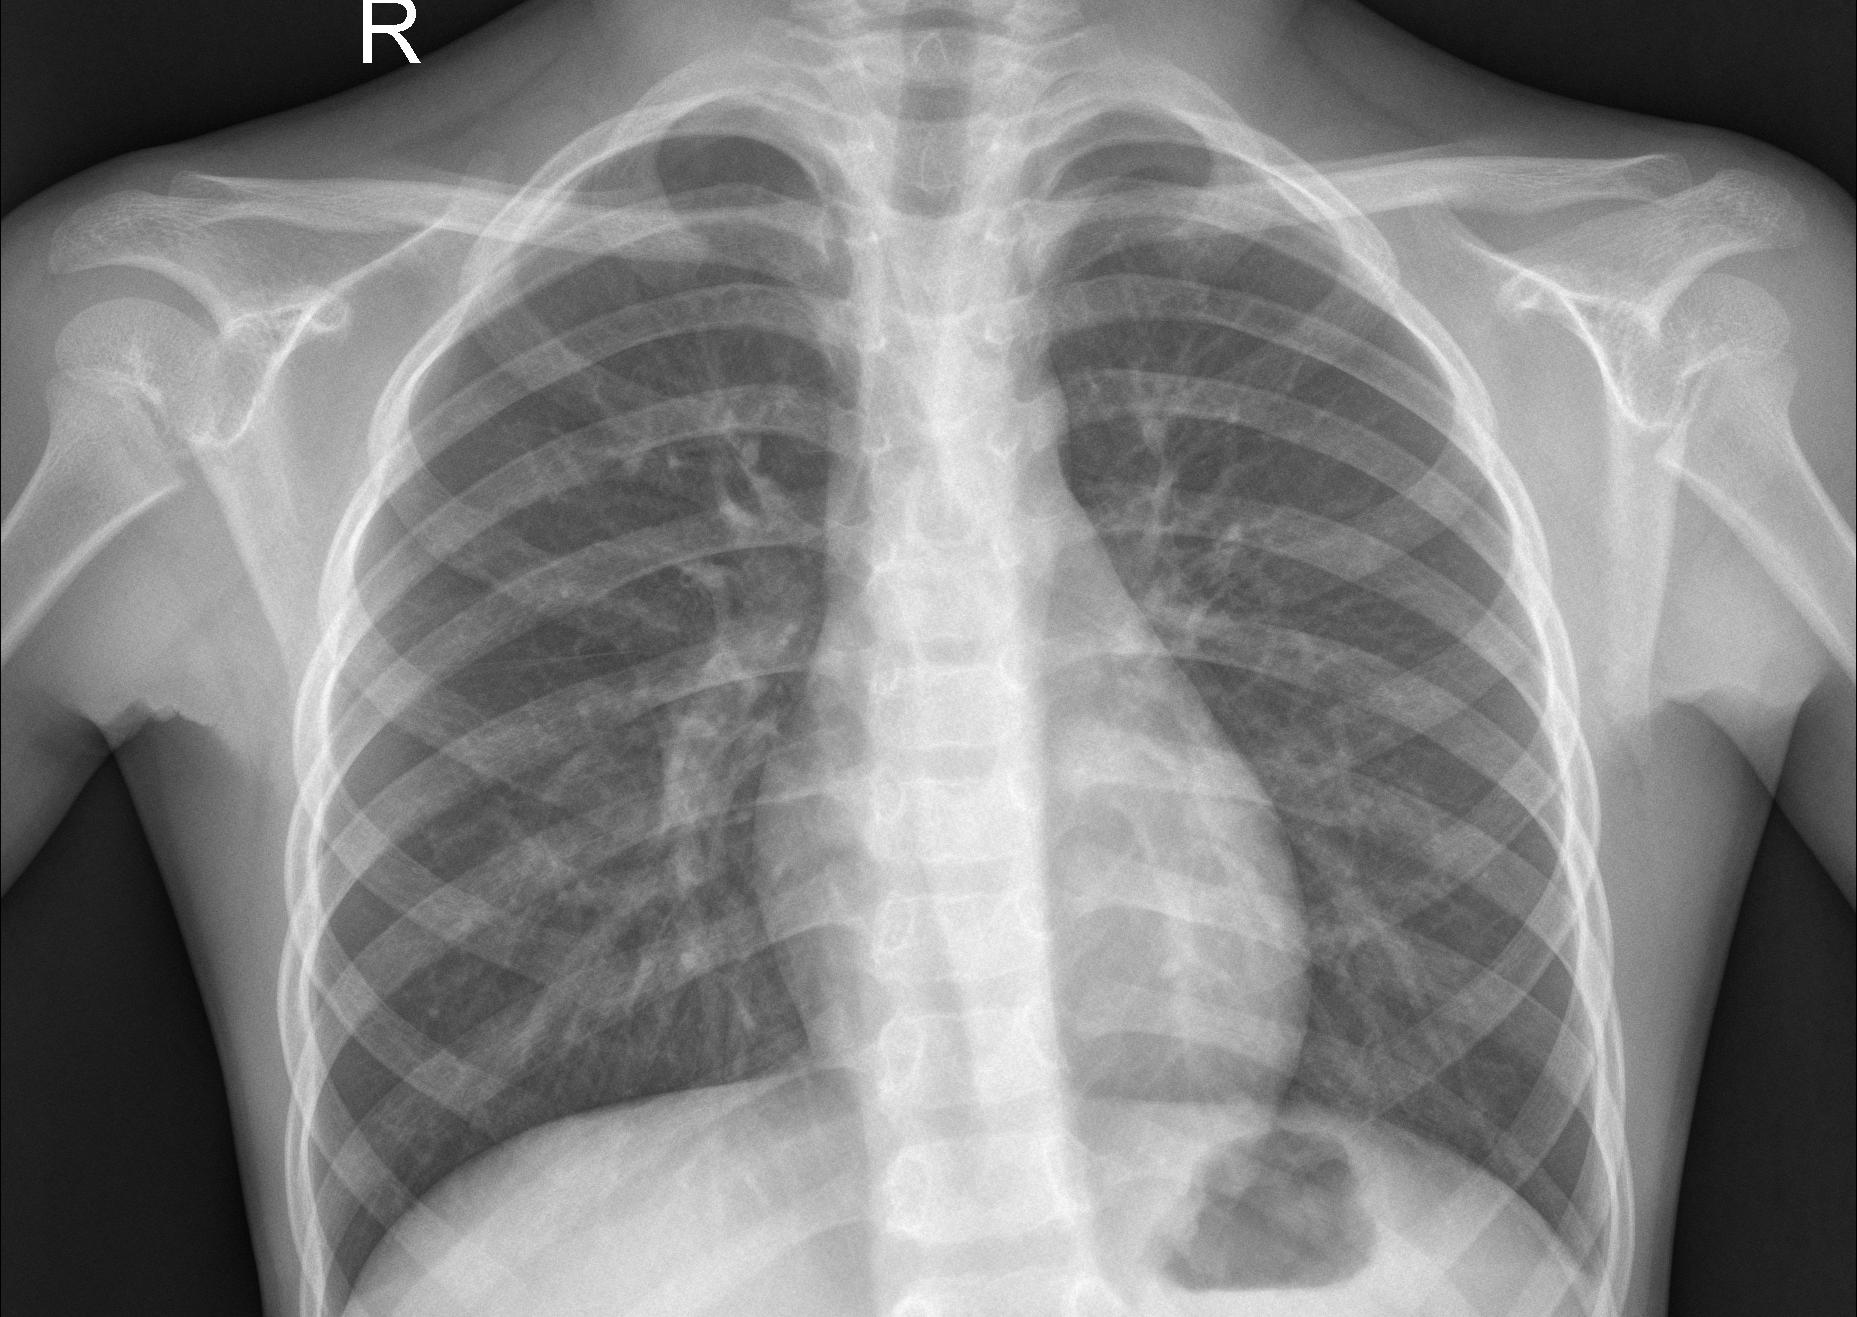

In [133]:
#Displaying a photo of a pneumonia picture from the test set
img_path_nm = "data/chest_xray/test/Normal/IM-0001-0001.jpeg"
Load_image_nm = tf.keras.preprocessing.image.load_img(img_path_nm)
Load_image_nm

#### Model 10 predictions

In [134]:
test_loss, test_acc = model_10.evaluate(test_generator, steps = 20)
print('Test Accuracy: ',test_acc)

20/20 [==============================] - 8s 407ms/step - loss: 0.4444 - binary_accuracy: 0.8269
Test Accuracy:  0.8269230723381042


In [135]:
test_predictions_1 = get_predictions(model_10, test_generator)

AUC: 0.9403900942362482


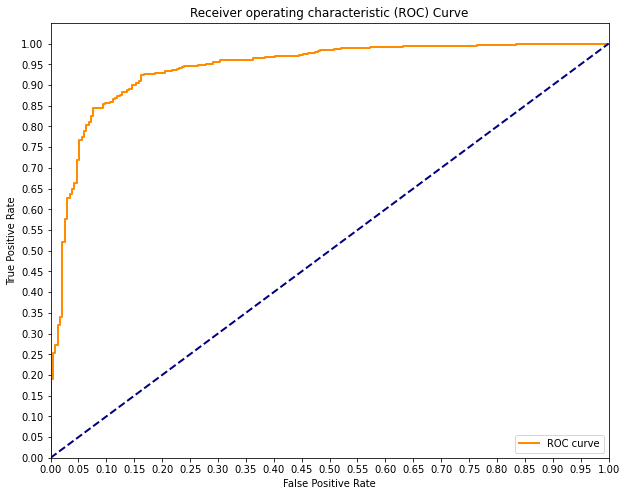

In [136]:
plot_roc_auc(test_predictions_1[0], test_predictions_1[1])

#### Model 13 predictions

In [137]:
test_loss, test_acc = model_13.evaluate(test_generator, steps = 20)
print('Test Accuracy: ',test_acc)

20/20 [==============================] - 36s 2s/step - loss: 3.0236 - binary_accuracy: 0.7404
Test Accuracy:  0.7403846383094788


In [138]:
test_predictions_2 = get_predictions(model_13, test_generator)

AUC: 0.9042735042735043


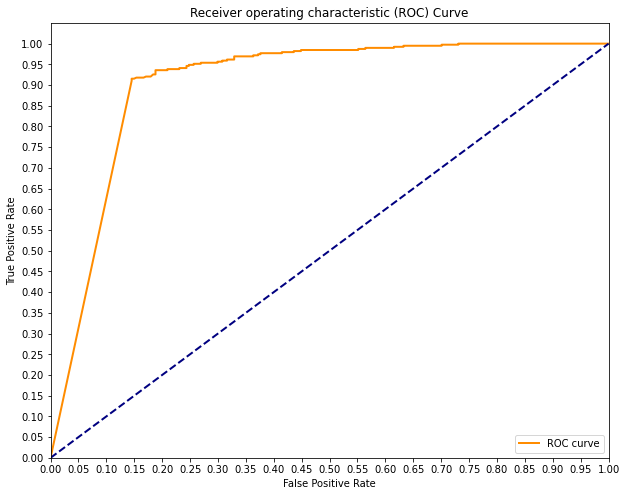

In [139]:
plot_roc_auc(test_predictions_2[0], test_predictions_2[1])

#### Model 14 predictions

In [140]:
test_loss, test_acc = model_14.evaluate(test_generator, steps = 20)
print('Test Accuracy: ',test_acc)

20/20 [==============================] - 34s 2s/step - loss: 0.4715 - binary_accuracy: 0.8542
Test Accuracy:  0.8541666865348816


In [141]:
test_predictions_3 = get_predictions(model_14, test_generator)

AUC: 0.9381985535831691


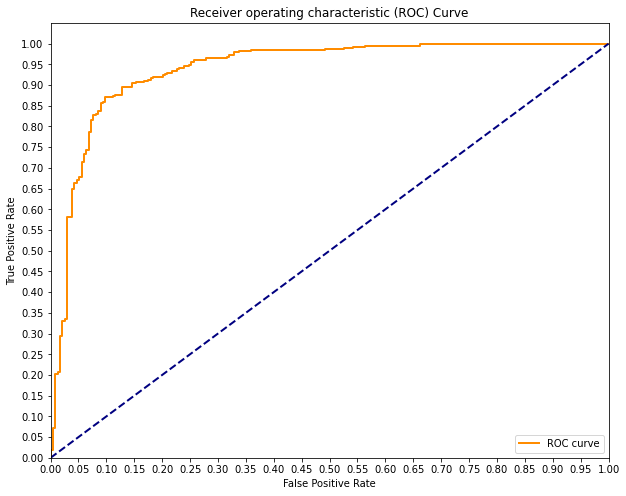

In [142]:
plot_roc_auc(test_predictions_3[0], test_predictions_3[1])

### Final Confusion Matrix to see the full performance on the test set

#### Model 10 Confusion Matrix

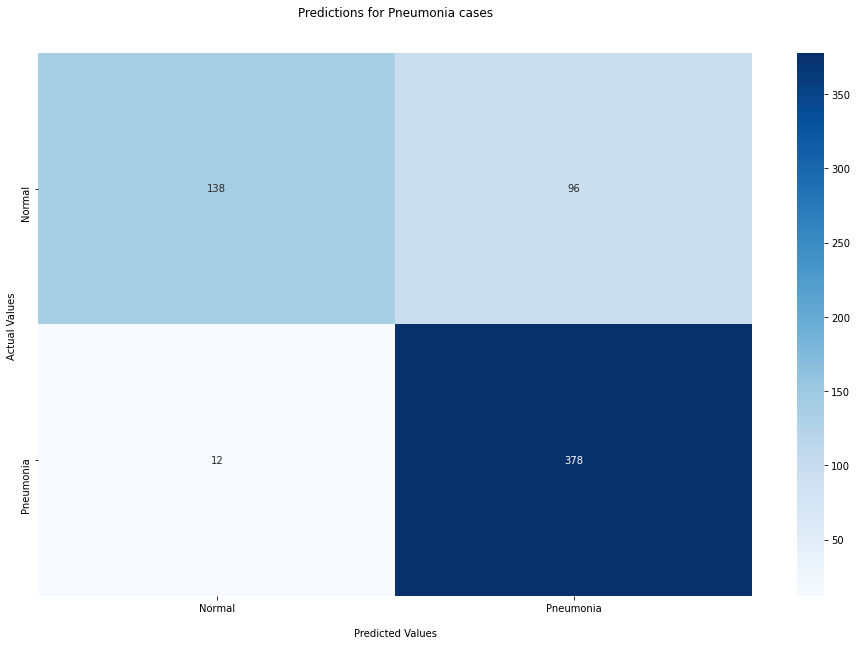

In [143]:
#Plotting confusion matrix with counts
plot_confusion_matrix(test_predictions_1[0], test_predictions_1[1])

In [144]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(test_predictions_1[0], test_predictions_1[1])

#### Model 13 Confusion Matrix

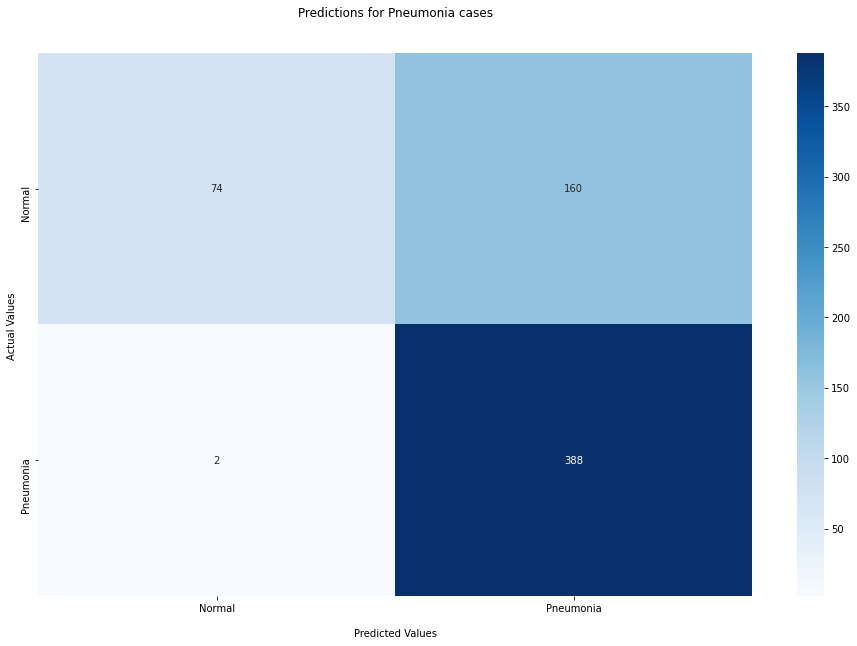

In [145]:
#Plotting confusion matrix with counts
plot_confusion_matrix(test_predictions_2[0], test_predictions_2[1])

In [146]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(test_predictions_2[0], test_predictions_2[1])

#### Model 14 Confusion Matrix

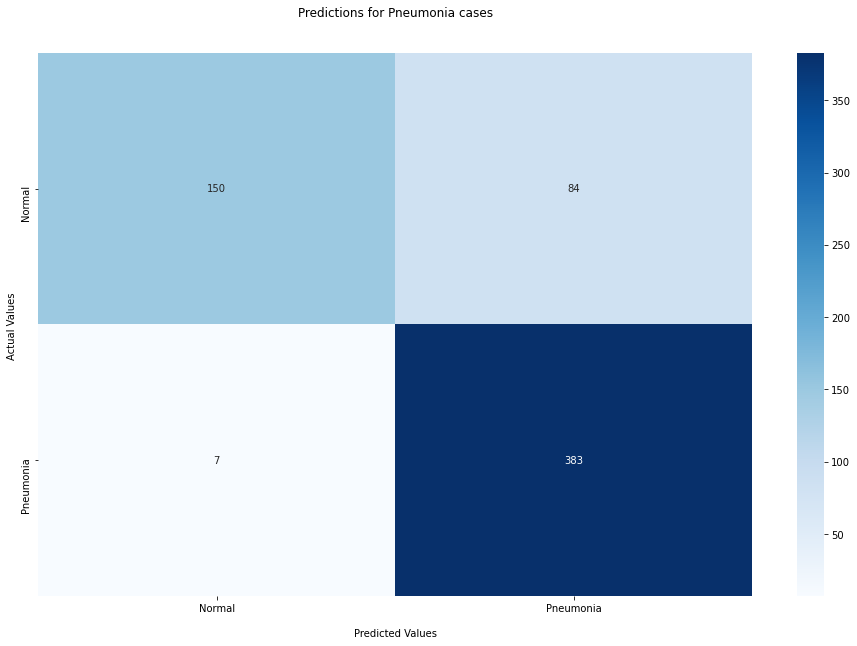

In [147]:
#Plotting confusion matrix with counts
plot_confusion_matrix(test_predictions_3[0], test_predictions_3[1])

In [148]:
#Plotting confusion matrix with percentages
plot_confusion_matrix_normalized(test_predictions_3[0], test_predictions_3[1])

# Final Conclusion

* The best model on the test set will be model 14, the model using Resnet152V2. It had the best overall score as it predicted Pneumonia for Pneumonia X-rays 98.2% of the time and Normal for Pneumonia X-rays 1.8% the of the time. It also had the least trouble when it came to predicting Pneumonia in Normal cases as well. This model also had the best evaluate score on the test evaluation at ~85.4


* Model 13 was able to detect Pneumonia cases 99.5 percent of the time however, it is misclassifying normal cases as a much higher rate than model 14. This model also had the lowest test evaluation score of the 3 at ~74%.


* Model 10 was very close to model 14 but model 14 was able to predict Pneumonia cases ~1.3% better and was more balanced than model 13. This model had an test evaluation score of ~82.7%